# 0.Introduction

## 0.1 Libraries

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import glob
from pandas import DataFrame
from scipy import stats
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import GradientBoostingRegressor
import warnings
from sklearn import linear_model
from sklearn.metrics import r2_score, explained_variance_score, mean_absolute_error, mean_squared_error
from sklearn.linear_model import LogisticRegression, Perceptron
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.impute import SimpleImputer
from sklearn.model_selection import KFold
from keras.utils.vis_utils import plot_model
from tensorflow import keras
from sklearn.svm import SVR
import datetime
import seaborn as sns
from os import listdir
from os.path import isfile, join
from sklearn.preprocessing import StandardScaler, MinMaxScaler,FunctionTransformer, PowerTransformer, QuantileTransformer, RobustScaler
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.wrappers.scikit_learn import KerasRegressor
from tensorflow.keras import activations
from keras.callbacks import EarlyStopping,ModelCheckpoint
from sklearn.linear_model import LinearRegression
from sklearn.impute import KNNImputer
from IPython.display import display_html 
from re import VERBOSE
from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline
from sklearn import set_config
from sklearn.compose import ColumnTransformer
from pyparsing.helpers import disable_diag
from scipy.stats.mstats import winsorize

warnings.filterwarnings("ignore", category= RuntimeWarning)
warnings.filterwarnings("ignore", category= FutureWarning)
set_config(display="diagram")

## 0.2 Variables

In [ ]:
#dataframe to save various results
results_mse = pd.DataFrame(columns=['modelName', 'train_mse', 'test_mse', 'difference'])
results_mae = pd.DataFrame(columns=['modelName', 'train_mae', 'test_mae', 'difference'])
results_r2score = pd.DataFrame(columns=['modelName', 'train_r2score', 'test_r2score', 'difference'])
results_evs = pd.DataFrame(columns=['modelName', 'train_evs', 'test_evs', 'difference'])

## 0.3 Functions

### -data preparation

In [ ]:
#checks missing data in %-tage in given dataset
def checkDataForNulls (dataset):
    percent_missing = dataset.isnull().sum() * 100 / len(dataset)
    missing_value_df = pd.DataFrame({'Column': dataset.columns,
                                 'percent_missing': percent_missing})
    print(missing_value_df)

In [ ]:
#show boxplot for dataset befroe modifications and after
def boxplot_compare_dist(df, y_before, y_after):
    f = plt.figure(figsize=(16,8))
    st = f.suptitle(f"{y_before} comparison", fontsize="x-large")
    ax1=plt.subplot(2,2,1)
    a = sns.distplot(df[y_before])
    plt.subplot(2,2,3)
    sns.boxplot(y=y_before, data = df)
    ax2=plt.subplot(2,2,2)
    b = sns.distplot(df [y_after])
    plt.subplot(2,2,4)
    sns.boxplot(y=y_after, data = df)
    a.title.set_text('before')
    b.title.set_text('after')
    plt.show()

In [ ]:
#transform specific column with requested tranfromer
def transform (transf, X_train, X_test, name, col):
  #train
  X_train_df = pd.DataFrame(X_train, columns = ['AT','V', 'AP', "RH"])
  X_train_df = X_train_df.drop(['AT','V'], axis=1)
  data_trans = transf.fit_transform(X_train_df) 
  data_trans_df = pd.DataFrame(data_trans, columns = ['AP', "RH"])

  #test
  X_test_df = pd.DataFrame(X_test, columns = ['AT','V', 'AP', "RH"])
  X_test_df = X_test_df.drop(['AT','V'], axis=1)
  data_trans_test = transf.transform(X_test_df)
  data_trans_test_df = pd.DataFrame(data_trans_test, columns = ['AP', "RH"])

  #show results
  compare_to_normal (X_train_df,data_trans_df, col, f'{name}_Train')
  compare_to_normal (X_test_df,data_trans_test_df, col, f'{name}_Test')
  return data_trans, data_trans_test

In [ ]:
#iterate over list of transformers and check specific column
def transform_list(X_train, X_test, col):
    rcpr_transformer = FunctionTransformer(lambda x: 1/x, validate = True)
    sqr_transformer = FunctionTransformer(lambda x: x ** (1 / 2), validate = True)
    exp_transformer = FunctionTransformer(lambda x: x **( 1 * 1.2), validate = True)
    yj_transformer = PowerTransformer(method = 'yeo-johnson', standardize = False)
    bc_transformer = PowerTransformer(method = 'box-cox', standardize = False)
    transformer_list=[rcpr_transformer,sqr_transformer, exp_transformer, yj_transformer, bc_transformer ]
    transformer_names = ["rcpr_transformer","sqr_transformer", "exp_transformer", "yj_transformer", "bc_transformer" ]
    for j in range(0, len(transformer_list)):
         transform(transformer_list[j] ,X_train, X_test, transformer_names[j], col) 

In [ ]:
def transform_y (y_train,y_test):
  y_target = y_train.to_numpy()
  y_tr_test = y_test.to_numpy()

  y_data = y_target.reshape(len(y_target), 1)
  y_data_test = y_tr_test.reshape(len(y_tr_test), 1)

  # QuantileTransformer to make bimodel to uniform
  quant_trans = QuantileTransformer(n_quantiles=300, output_distribution='uniform')

  y_trans = quant_trans.fit_transform(y_data)
  y_trans_test = quant_trans.transform(y_data_test)
  return y_target, y_trans,  y_tr_test, y_trans_test

In [ ]:
#plot specific column before modification and after modification in comparison to normal destribution
def compare_to_normal (df_before,df_after, col, name):
    f = plt.figure(figsize = (50, 10))
    st = f.suptitle(f"{col}_{name}", fontsize=30)
    plt.subplot(1, 4, 1)
    data = df_before[col]
    ax = sns.histplot(x=data, stat="density")
    mean = data.mean()
    std = data.std()
    x = np.linspace(mean-4*std, mean+4*std, 200)
    p = stats.norm.pdf(x, mean, std)
    plt.plot(x, p, color="black", linewidth=2)
    plt.xlabel(f'{col} before transformation', fontsize=20)
    plt.subplot(1, 4, 2)
    stats.probplot(df_before[col], dist = 'norm', plot = plt)
    plt.xlabel(f'{col} before transformation', fontsize=20)
    plt.subplot(1, 4, 3)
    data = df_after[col]
    ax = sns.histplot(x=data, stat="density")
    mean = data.mean()
    std = data.std()
    x = np.linspace(mean-4*std, mean+4*std, 200)
    p = stats.norm.pdf(x, mean, std)
    plt.plot(x, p, color="black", linewidth=2)
    plt.xlabel(f'{col} after transformation', fontsize=20)
    plt.subplot(1, 4, 4)
    stats.probplot(df_after[col], dist = 'norm', plot = plt)
    plt.xlabel(f'{col} after transformation', fontsize=20)
    plt.show()

In [ ]:
#split and impute dataset
def reset_t_t_split(df, imputer):
  X = df.iloc[:, :-1].values
  y= df.iloc[:, -1].values
  #split
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42)
  #impute
  X_train_i = imputer.fit_transform(X_train)
  X_test_i = imputer.transform(X_test)
  return X_train_i, X_test_i, y_train, y_test

In [ ]:
# scale only
def scale (scaler, X_train_i, X_test_i, y_train, y_test ):
  #scale
  sc_x=scaler
  sc_y=scaler
  y_train_r = y_train.reshape(len(y_train), 1)
  y_test_r = y_test.reshape(len(y_test), 1)
  X_train_sc = sc_x.fit_transform(X_train_i)
  X_test_sc = sc_x.transform(X_test_i)
  y_train_sc = sc_y.fit_transform(y_train_r)
  y_test_sc = sc_y.transform(y_test_r)
  
  return  X_train_sc, X_test_sc, y_train_sc, y_test_sc, sc_y, y_test, y_train

In [ ]:
def transform_scale_RH (RH_transformer, df, scaler):
  X_train_o, X_test_o, y_train, y_test = reset_t_t_split(df, KNNImputer(n_neighbors=2))
  #train and test numpy array with transfromed RH col
 
  RH_train, RH_test = transform(RH_transformer,X_train_o, X_test_o, 'final_transform_box_cox', 'RH')

  RH_train_col = RH_train[:,[1]]
  X_train_mod = X_train_o[:,[0,1,2]]
  X_train_final_RH = np.append(X_train_mod, RH_train_col, axis=1)


  RH_test_col = RH_test[:,[1]]
  X_test_mod = X_test_o[:,[0,1,2]]
  X_test_final_RH = np.append(X_test_mod, RH_test_col, axis=1)

  X_train, X_test, y_train, y_test, sc_y, y_test_orig, y_train_orig = scale(scaler, X_train_final_RH, X_test_final_RH , y_train, y_test)
  return X_train, X_test, y_train, y_test, sc_y, y_test_orig, y_train_orig

### -model training

In [ ]:
#split dataset and preprocess data according to given pipeline
def split_impute_scale_pipe (df, pipe, imputer, winsorize_rh = False,winsorize_ap = False):
  pipe_s = define_pipeline_simple(RobustScaler())
  X = df.iloc[:, :-1].values
  y= df.iloc[:, -1].values
  #split
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42)

  y_test_orig, y_train_orig = y_test, y_train

  X_train_i = imputer.fit_transform(X_train)
  X_test_i = imputer.transform(X_test)

  cols = ['AT', 'V', 'AP', 'RH']
  if winsorize_rh:
    X_train_i = winsorize_nparray(X_train_i, 3,  0.00135, 0)
    X_test_i = winsorize_nparray(X_test_i, 3,  0.00135, 0)
    
  if winsorize_ap:
    X_train_i= winsorize_nparray(X_train_i, 2,  0.00165, 0.015)
    X_test_i= winsorize_nparray(X_test_i, 2,  0.00165, 0.015)
    cols = ['AT', 'V', 'RH', 'AP']

  X_train_i = pd.DataFrame(X_train_i, columns = cols)
  X_test_i = pd.DataFrame(X_test_i, columns = cols)

  X_train_p = pipe.fit_transform(X_train_i)
  X_test_p = pipe.transform(X_test_i)

  pipe 

  y_train_r = y_train.reshape(len(y_train), 1)
  y_test_r = y_test.reshape(len(y_test), 1)
  y_train_p = pipe_s.fit_transform(y_train_r)
  y_test_p = pipe_s.transform(y_test_r)

  return X_train_p, X_test_p, y_train_p, y_test_p, pipe_s,  y_test_orig, y_train_orig

In [ ]:
#define pipeline with scaler only
def define_pipeline_simple(scaler):
  pipe_simple = Pipeline([
    ('scaler', scaler)
    ])
  return pipe_simple

In [ ]:
#define pipeline with transformer and scaler:

def define_pipeline_complex(scaler, rh_step, ap_step, is_rh = True, is_ap = True ):
  if is_rh:
    rh_pipe = Pipeline([('transformer_step', rh_step),
                        ('scaler', scaler)])
  else:
    rh_pipe = Pipeline([('scaler', scaler)])
  
  if is_ap:
    ap_pipe = Pipeline([('preprocess_step', ap_step),
                        ('scaler', scaler)])
  else:
    ap_pipe =  Pipeline([('scaler', scaler)])

  simple_pipe = define_pipeline_simple(RobustScaler())                        
  pipe = ColumnTransformer(
    [("RH_col"  , rh_pipe  , ["RH"]),
     ("AP_col", ap_pipe, ["AP"])
    ],
    remainder = simple_pipe
  )
  set_config(display="diagram")

  return pipe

In [ ]:
def winsorize_nparray(nparray, col_index, lower, upper):
  array_col =  nparray[ : , col_index]
  array_col_win = winsorize(array_col, (lower, upper))
  array_col_win_reshape = array_col_win.reshape(len(array_col_win), 1)
  combo = np.delete(nparray, col_index, 1)
  nparray = np.c_[combo, array_col_win_reshape]
  return nparray

#### -ML model training

In [ ]:
#train ML model, evaluate, save to results dataframe
def train_report_hist_pipe (name,regressor, pipe):
    model = regressor
    model.fit(X_train, y_train)
    results = pd.DataFrame(columns=['modelName', 'mse', 'mae',  'evs', 'r2'])


    r_sq = model.score(X_train, y_train)
    print(f"coefficient of determination: {r_sq}")
#train
    y_pred_train = pipe.inverse_transform(model.predict(X_train).reshape(-1,1))

    r2_score_train =  r2_score(y_train_orig, y_pred_train)
    evs_train = explained_variance_score(y_train_orig, y_pred_train)
    mae_train =  mean_absolute_error(y_train_orig, y_pred_train)
    mse_train = mean_squared_error(y_train_orig, y_pred_train)
#test
    y_pred_test = pipe.inverse_transform(model.predict(X_test).reshape(-1,1))
  
    r2_score_test =  r2_score(y_test_orig, y_pred_test)
    evs_test = explained_variance_score(y_test_orig, y_pred_test)
    mae_test =  mean_absolute_error(y_test_orig, y_pred_test)
    mse_test = mean_squared_error(y_test_orig, y_pred_test)
#difference
    diff_r2 = r2_score_train - r2_score_test
    diff_evs = evs_train - evs_test
    diff_mae = mae_test - mae_train
    diff_mse = mse_test - mse_train

    results_r2score.loc[len(results_r2score.index)] = [name, round( r2_score_train*100,3), round( r2_score_test*100,3), round( diff_r2*100,3)]
    results_evs.loc[len(results_evs.index)] = [name, round( evs_train*100,3), round( evs_test*100,3), round( diff_evs*100,3)]
    results_mae.loc[len(results_mae.index)] = [name, round( mae_train,3), round( mae_test,3), round( diff_mae,3)]
    results_mse.loc[len(results_mse.index)] = [name, round( mse_train,3), round( mse_test,3), round( diff_mse,3)]

    results.loc[len(results.index)] = [f'{name}_train', round( mse_train,3), round( mae_train,3),round( evs_train*100,3),round( r2_score_train*100,3) ]
    results.loc[len(results.index)] = [f'{name}_test', round( mse_test,3), round( mae_test,3),round( evs_test*100,3),round( r2_score_test*100,3) ]

    print (results)

#### -ANN model training

In [ ]:
#define model architecture and complie model
def define_model (name, opt, n_layers, unt, input_vec_len):
  model = tf.keras.models.Sequential()
  model.add(tf.keras.layers.Dense(units = unt, activation = 'relu', input_shape = (input_vec_len,)))
  for n in range(1, n_layers):
     model.add(tf.keras.layers.Dense(units = unt, activation = 'relu'))
  model.add(tf.keras.layers.Dense(units = 1))
  model.compile(optimizer = opt, loss="mse",  metrics = ['mae'])
  return model

In [ ]:
#evaluate model
def evaluate_model_pipe (name, pipe, pat,  n_layers, unt, batch, opt, ep,  n_folds = 5):
  histories = list()
  early_stopping_monitor = EarlyStopping(patience=pat)
  checkpointer = ModelCheckpoint(
      filepath = f'/content/drive/MyDrive/Colab Notebooks/4.ML_ANN_Project/weights_and_models/resnet-weights_{name}.hdf5',
      verbose = 1,
      save_best_only = True
  )
  input_vec_len = X_train.shape[1]
  name = define_model(name, opt, n_layers, unt, input_vec_len)
  history = name.fit(X_train, y_train, epochs = ep, batch_size = batch, verbose = 0, validation_data=(X_test, y_test), callbacks= [early_stopping_monitor, checkpointer])
  histories.append(history)
  _y_pred_test = name.predict(X_test).reshape(-1,1)
  y_pred_test = pipe.inverse_transform(_y_pred_test)
  y_pred_train = pipe.inverse_transform(name.predict(X_train).reshape(-1,1))
  return histories, y_pred_test, y_pred_train

In [ ]:
#plot diagnostic learning curves
def show_plots (histories, name):
  f = plt.figure(figsize=(30,4))
  st = f.suptitle(name, fontsize="x-large")

  plt.subplot(1,2,1)
  # plot loss during training
  plt.title('Loss (Mean Squared Error)')
  plt.plot(histories[0].history['loss'], label='train mse')
  plt.plot(histories[0].history['val_loss'], label='test mse')
  ax = plt.gca()
  ax.get_yaxis().set_visible(False)
  plt.legend()

  plt.subplot (1,2,2)
  plt.title('Mean Absolute Error')
  plt.plot(histories[0].history['mae'], label='train mae')
  plt.plot(histories[0].history['val_mae'], label='test mae')
  axes = plt.gca()
  axes.get_yaxis().set_visible(False)
  plt.legend()

  plt.savefig(f"{name} model results.pdf") 
  plt.show()

In [ ]:
#count results and save to dataframe
def results(name,  y_pred_test,  y_pred_train):
  r2_score_train = round(r2_score(y_train_orig, y_pred_train)*100,3)
  evs_train = round(explained_variance_score(y_train_orig, y_pred_train)*100,3)
  mae_train = mean_absolute_error(y_train_orig, y_pred_train)
  mse_train = mean_squared_error(y_train_orig, y_pred_train)

  r2_score_test = round(r2_score(y_test_orig, y_pred_test)*100,3)
  evs_test = round(explained_variance_score(y_test_orig, y_pred_test)*100,3)
  mae_test = mean_absolute_error(y_test_orig, y_pred_test)
  mse_test = mean_squared_error(y_test_orig, y_pred_test)

  #difference
  diff_r2 = r2_score_train - r2_score_test
  diff_evs = evs_train - evs_test
  diff_mae = mae_test - mae_train
  diff_mse = mse_test - mse_train

  results_r2score.loc[len(results_r2score.index)] = [name, r2_score_train, r2_score_test, round(diff_r2,3)]
  results_evs.loc[len(results_evs.index)] = [name, evs_train, evs_test, round( diff_evs,3)]
  results_mae.loc[len(results_mae.index)] = [name, round( mae_train,3), round( mae_test,3), round( diff_mae,3)]
  results_mse.loc[len(results_mse.index)] = [name, round( mse_train,3), round( mse_test,3), round( diff_mse,3)]

  results = pd.DataFrame(columns = ['type', 'mean_squared_error', 'mean_absolute_error',  'r2_score', 'e_v_score'])
  results.loc[0] = [f"train:_{name}", round( mse_train,3),round( mae_train,3), r2_score_train ,evs_train]
  results.loc[1] = [f"test:_{name}",  round( mse_test,3) , round( mae_test,3) , r2_score_test ,evs_test]
  results.loc[2] = [f"{name}", round( diff_mse,3) , round( diff_mae,3) , round( diff_r2,3) ,round( diff_evs,3)]

  print(results)
  return results

In [ ]:
# complete run from model training, evaluation, vizualization and resalts saving
def complete_run (name, pipe,ep = 450, pat = 50, opt = 'adam', n_layers = 1, unt = 6, batch = 256):

  histories, y_pred_test, y_pred_train = evaluate_model_pipe (name, pipe, pat, n_layers, unt, batch, opt, ep,  n_folds = 5)

  show_plots(histories, name)
  
  data_res = results(name,  y_pred_test,  y_pred_train)
  data_res.to_csv(f'/content/drive/MyDrive/Colab Notebooks/4.ML_ANN_Project/results/{name}_results.csv', index=False) 

In [ ]:
#upload results from path and save to main results df
def upload_save_results(df):
  name = df.loc[2]['type']
  r2_score_train = df.loc[0]['r2_score']
  evs_train = df.loc[0]['e_v_score']
  mae_train = df.loc[0]['mean_absolute_error']
  mse_train = df.loc[0]['mean_squared_error']

  r2_score_test = df.loc[1]['r2_score']
  evs_test = df.loc[1]['e_v_score']
  mae_test = df.loc[1]['mean_absolute_error']
  mse_test = df.loc[1]['mean_squared_error']

    #difference
  diff_r2 = df.loc[2]['r2_score']
  diff_evs = df.loc[2]['e_v_score']
  diff_mae = df.loc[2]['mean_absolute_error']
  diff_mse = df.loc[2]['mean_squared_error']

  results_r2score.loc[len(results_r2score.index)] = [name, r2_score_train, r2_score_test, diff_r2]
  results_evs.loc[len(results_evs.index)] = [name, evs_train, evs_test, diff_evs]
  results_mae.loc[len(results_mae.index)] = [name, mae_train, mae_test, diff_mae]
  results_mse.loc[len(results_mse.index)] = [name, mse_train, mse_test, diff_mse]

In [ ]:
#update results from saved files
def update_results(isFinal = False):
  mypath = '/content/drive/MyDrive/Colab Notebooks/4.ML_ANN_Project/results'
  if isFinal:
    mypath = '/content/drive/MyDrive/Colab Notebooks/4.ML_ANN_Project/results_final'
  onlyfiles = [f for f in listdir(mypath) if isfile(join(mypath, f))]
  for file in onlyfiles:
    df = pd.read_csv(f"{mypath}/{file}")
    upload_save_results(df)

In [ ]:
#save model as json file
def save_model_as_json(model,name):
  model_json = model.to_json()
  with open(f'/content/drive/MyDrive/Colab Notebooks/4.ML_ANN_Project/weights_and_models/resnet-classifier-model_{name}.json', 'w') as json_file:
    json_file.write(model_json)

### -show results

In [ ]:
def percent_graph (df, test):
  N = len(df.iloc[:10])
  new_df = df.sort_values(test, ascending=True).iloc[:10]
  ind = np.arange(N) 
  name = new_df['modelName'].head(12)
  # Figure Size
  fig, ax = plt.subplots(figsize =(20, 7))
  ax.barh(name, new_df[test].values.tolist(), color = 'orange')
  ax.barh(name, new_df['difference'].values.tolist(), left = new_df[test].values.tolist())
  for bar, disease in zip(ax.patches,new_df[test].values.tolist()):
      ax.text(0.3, bar.get_y()+bar.get_height()/2, disease, color = 'white', fontsize=15, ha = 'left', va = 'center') 
  plt.show()

In [ ]:
def failure_graph (df, train, test):
  N = len(df)
  new_df = df.sort_values(test, ascending=False)
  ind = np.arange(N) 
  name = new_df['modelName'].head(12)
  # Figure Size
  fig, ax = plt.subplots(figsize =(20, 7))
  ax.barh(name, new_df[train].values.tolist())
  ax.barh(name, new_df['difference'].values.tolist(), left = new_df[train].values.tolist())
  for bar, disease in zip(ax.patches,new_df[test].values.tolist()):
    ax.text(0.3, bar.get_y()+bar.get_height()/2, disease, color = 'orange',fontsize=15, ha = 'left', va = 'center') 
  plt.show()

In [ ]:
def show_results(isGraph = True):
    new_results_mse = results_mse.sort_values('test_mse', ascending=True)
    new_results_mae = results_mae.sort_values('test_mae', ascending=True)
    new_results_r2score = results_r2score.sort_values('test_r2score', ascending=False)
    new_results_evs = results_evs.sort_values('test_evs', ascending=False)

    df1_styler = new_results_mse.style.set_table_attributes('border="1" class="dataframe table table-hover table-bordered" style="display:inline"').set_precision(3).set_caption('MSE')
    df2_styler = new_results_mae.style.set_table_attributes('border="1" class="dataframe table table-hover table-bordered" style="display:inline"').set_precision(3).set_caption('MAE')
    df3_styler = new_results_r2score.style.set_table_attributes('border="1" class="dataframe table table-hover table-bordered" style="display:inline"').set_precision(3).set_caption('r2score')
    df4_styler = new_results_evs.style.set_table_attributes('border="1" class="dataframe table table-hover table-bordered" style="display:inline"').set_precision(3).set_caption('EVS')
    
    display_html(df1_styler._repr_html_()+"____\n"+df2_styler._repr_html_()+"____"+df3_styler._repr_html_()+"____"+df4_styler._repr_html_(), raw=True)

    m_mse = new_results_mse['modelName'].to_list()
    tr_mse = new_results_mse['train_mse'].to_list()
    te_mse = new_results_mse['test_mse'].to_list()

    m_mae = new_results_mae['modelName'].to_list()
    tr_mae = new_results_mae['train_mae'].to_list()
    te_mae = new_results_mae['test_mae'].to_list()

    m_r2score = new_results_r2score['modelName'].to_list()
    tr_r2score = new_results_r2score['train_r2score'].to_list()
    te_r2score = new_results_r2score['test_r2score'].to_list()

    m_evs = new_results_evs['modelName'].to_list()
    tr_evs = new_results_evs['train_evs'].to_list()
    te_evs = new_results_evs['test_evs'].to_list()

    f = plt.figure(figsize=(40,15))
    st = f.suptitle('Results', fontsize="x-large")

    if isGraph:
      failure_graph(results_mse, 'train_mse', 'test_mse')
      failure_graph(results_mae, 'train_mae', 'test_mae')
      percent_graph (results_evs, 'test_evs')
      percent_graph (results_r2score, 'test_r2score')
    
    

# 1.BaseModel

In [ ]:
pp_dataset = pd.read_excel("/content/drive/MyDrive/Colab Notebooks/Folds5x2_pp_TP.xlsx")

In [ ]:
pipe_simple = define_pipeline_simple(StandardScaler())
X_train, X_test, y_train, y_test, pipe,  y_test_orig, y_train_orig = split_impute_scale_pipe (pp_dataset, pipe_simple, SimpleImputer(strategy = 'median'))
train_report_hist_pipe ("basemodel",LinearRegression(), pipe)

coefficient of determination: 0.9261519326237648
         modelName     mse    mae     evs      r2
0  basemodel_train  21.448  3.659  92.615  92.615
1   basemodel_test  22.164  3.687  92.441  92.440



Epoch 1: val_loss improved from inf to 0.56253, saving model to /content/drive/MyDrive/Colab Notebooks/4.ML_ANN_Project/weights_and_models/resnet-weights_base_ann.hdf5

Epoch 2: val_loss improved from 0.56253 to 0.27679, saving model to /content/drive/MyDrive/Colab Notebooks/4.ML_ANN_Project/weights_and_models/resnet-weights_base_ann.hdf5

Epoch 3: val_loss improved from 0.27679 to 0.17463, saving model to /content/drive/MyDrive/Colab Notebooks/4.ML_ANN_Project/weights_and_models/resnet-weights_base_ann.hdf5

Epoch 4: val_loss improved from 0.17463 to 0.13466, saving model to /content/drive/MyDrive/Colab Notebooks/4.ML_ANN_Project/weights_and_models/resnet-weights_base_ann.hdf5

Epoch 5: val_loss improved from 0.13466 to 0.10887, saving model to /content/drive/MyDrive/Colab Notebooks/4.ML_ANN_Project/weights_and_models/resnet-weights_base_ann.hdf5

Epoch 6: val_loss improved from 0.10887 to 0.09096, saving model to /content/drive/MyDrive/Colab Notebooks/4.ML_ANN_Project/weights_and_mo

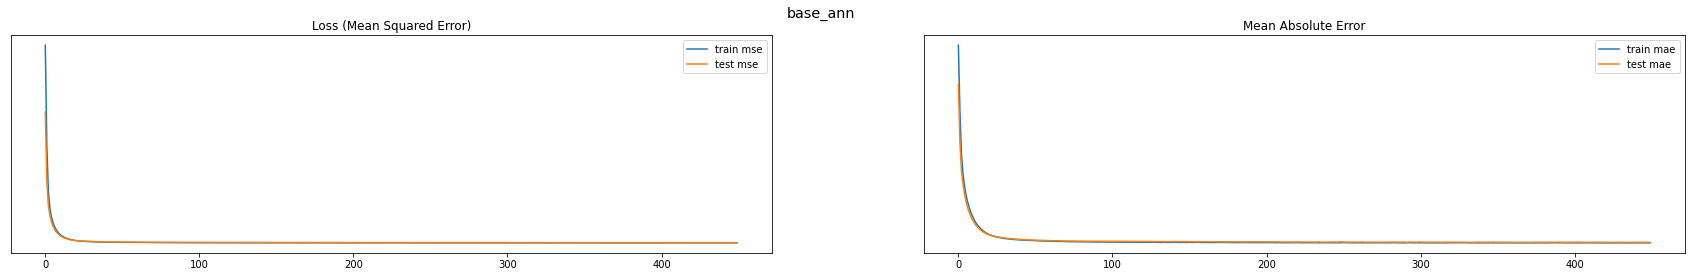

              type  mean_squared_error  mean_absolute_error  r2_score  \
0  train:_base_ann              17.774                3.253    93.880   
1   test:_base_ann              18.720                3.296    93.614   
2         base_ann               0.947                0.043     0.266   

   e_v_score  
0     93.883  
1     93.618  
2      0.265  


In [ ]:
pipe_simple = define_pipeline_simple(StandardScaler())
X_train, X_test, y_train, y_test, pipe,  y_test_orig, y_train_orig = split_impute_scale_pipe (pp_dataset, pipe_simple, SimpleImputer(strategy = 'median'))
complete_run ('base_ann', pipe)

# 2 ANN preprocessing tuning

## -winsorize


Epoch 1: val_loss improved from inf to 0.31327, saving model to /content/drive/MyDrive/Colab Notebooks/4.ML_ANN_Project/weights_and_models/resnet-weights_RS_RH_AP_winsorize_b_ann_knn.hdf5

Epoch 2: val_loss improved from 0.31327 to 0.22004, saving model to /content/drive/MyDrive/Colab Notebooks/4.ML_ANN_Project/weights_and_models/resnet-weights_RS_RH_AP_winsorize_b_ann_knn.hdf5

Epoch 3: val_loss improved from 0.22004 to 0.15692, saving model to /content/drive/MyDrive/Colab Notebooks/4.ML_ANN_Project/weights_and_models/resnet-weights_RS_RH_AP_winsorize_b_ann_knn.hdf5

Epoch 4: val_loss improved from 0.15692 to 0.11703, saving model to /content/drive/MyDrive/Colab Notebooks/4.ML_ANN_Project/weights_and_models/resnet-weights_RS_RH_AP_winsorize_b_ann_knn.hdf5

Epoch 5: val_loss improved from 0.11703 to 0.09249, saving model to /content/drive/MyDrive/Colab Notebooks/4.ML_ANN_Project/weights_and_models/resnet-weights_RS_RH_AP_winsorize_b_ann_knn.hdf5

Epoch 6: val_loss improved from 0.0924

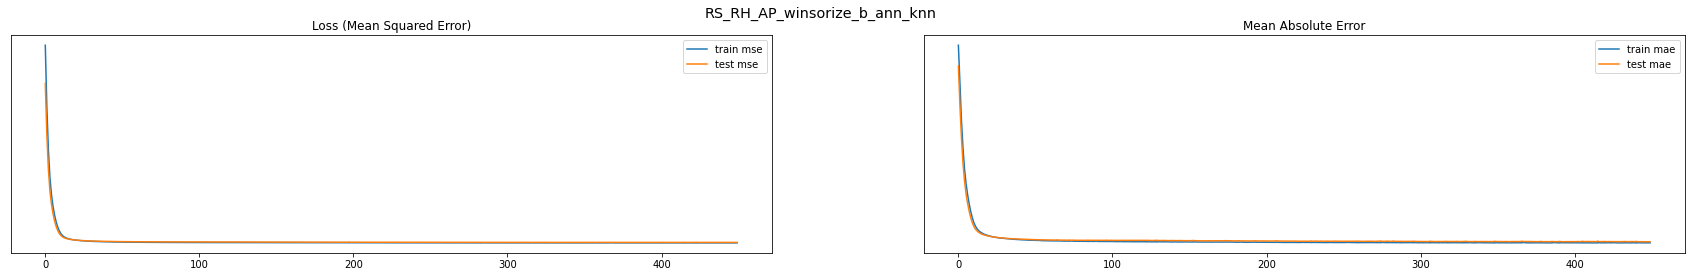

                                  type  mean_squared_error  \
0  train:_RS_RH_AP_winsorize_b_ann_knn              17.226   
1   test:_RS_RH_AP_winsorize_b_ann_knn              17.985   
2         RS_RH_AP_winsorize_b_ann_knn               0.759   

   mean_absolute_error  r2_score  e_v_score  
0                3.190    94.069     94.069  
1                3.261    93.865     93.866  
2                0.071     0.204      0.203  


In [ ]:
pipe_simple = define_pipeline_simple(RobustScaler())
X_train, X_test, y_train, y_test, pipe,  y_test_orig, y_train_orig = split_impute_scale_pipe (pp_dataset, pipe_simple, KNNImputer(n_neighbors=2), True, True)
complete_run ("RS_RH_AP_winsorize_b_ann_knn", pipe)


Epoch 1: val_loss improved from inf to 0.28040, saving model to /content/drive/MyDrive/Colab Notebooks/4.ML_ANN_Project/weights_and_models/resnet-weights_RS_RH_winsorize_b_ann_knn.hdf5

Epoch 2: val_loss improved from 0.28040 to 0.20530, saving model to /content/drive/MyDrive/Colab Notebooks/4.ML_ANN_Project/weights_and_models/resnet-weights_RS_RH_winsorize_b_ann_knn.hdf5

Epoch 3: val_loss improved from 0.20530 to 0.13494, saving model to /content/drive/MyDrive/Colab Notebooks/4.ML_ANN_Project/weights_and_models/resnet-weights_RS_RH_winsorize_b_ann_knn.hdf5

Epoch 4: val_loss improved from 0.13494 to 0.08446, saving model to /content/drive/MyDrive/Colab Notebooks/4.ML_ANN_Project/weights_and_models/resnet-weights_RS_RH_winsorize_b_ann_knn.hdf5

Epoch 5: val_loss improved from 0.08446 to 0.05869, saving model to /content/drive/MyDrive/Colab Notebooks/4.ML_ANN_Project/weights_and_models/resnet-weights_RS_RH_winsorize_b_ann_knn.hdf5

Epoch 6: val_loss improved from 0.05869 to 0.04830, s

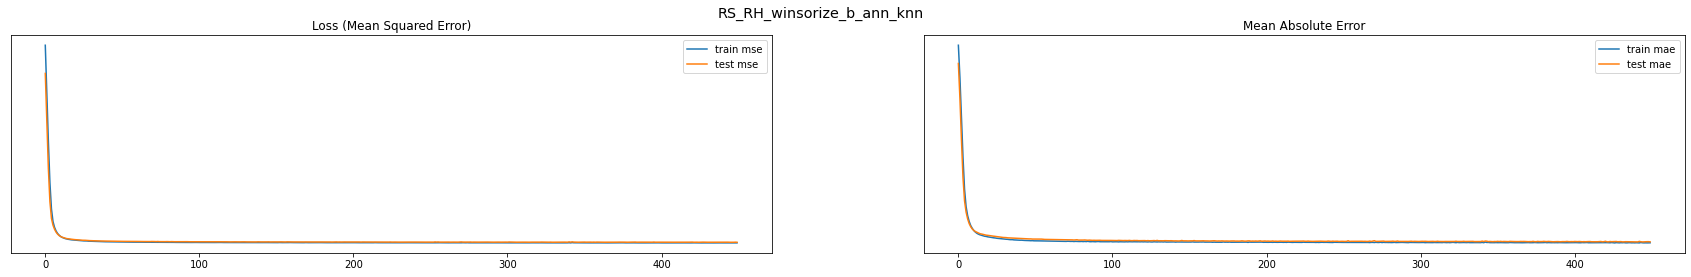

                               type  mean_squared_error  mean_absolute_error  \
0  train:_RS_RH_winsorize_b_ann_knn              16.943                3.185   
1   test:_RS_RH_winsorize_b_ann_knn              17.777                3.245   
2         RS_RH_winsorize_b_ann_knn               0.834                0.061   

   r2_score  e_v_score  
0    94.166     94.166  
1    93.936     93.936  
2     0.230      0.230  


In [ ]:
pipe_simple = define_pipeline_simple(RobustScaler())
X_train, X_test, y_train, y_test, pipe,  y_test_orig, y_train_orig = split_impute_scale_pipe (pp_dataset, pipe_simple, KNNImputer(n_neighbors=2), True, False)
complete_run ("RS_RH_winsorize_b_ann_knn", pipe)


Epoch 1: val_loss improved from inf to 0.30684, saving model to /content/drive/MyDrive/Colab Notebooks/4.ML_ANN_Project/weights_and_models/resnet-weights_RS_AP_winsorize_b_ann_knn.hdf5

Epoch 2: val_loss improved from 0.30684 to 0.21570, saving model to /content/drive/MyDrive/Colab Notebooks/4.ML_ANN_Project/weights_and_models/resnet-weights_RS_AP_winsorize_b_ann_knn.hdf5

Epoch 3: val_loss improved from 0.21570 to 0.15255, saving model to /content/drive/MyDrive/Colab Notebooks/4.ML_ANN_Project/weights_and_models/resnet-weights_RS_AP_winsorize_b_ann_knn.hdf5

Epoch 4: val_loss improved from 0.15255 to 0.11557, saving model to /content/drive/MyDrive/Colab Notebooks/4.ML_ANN_Project/weights_and_models/resnet-weights_RS_AP_winsorize_b_ann_knn.hdf5

Epoch 5: val_loss improved from 0.11557 to 0.09474, saving model to /content/drive/MyDrive/Colab Notebooks/4.ML_ANN_Project/weights_and_models/resnet-weights_RS_AP_winsorize_b_ann_knn.hdf5

Epoch 6: val_loss improved from 0.09474 to 0.08265, s

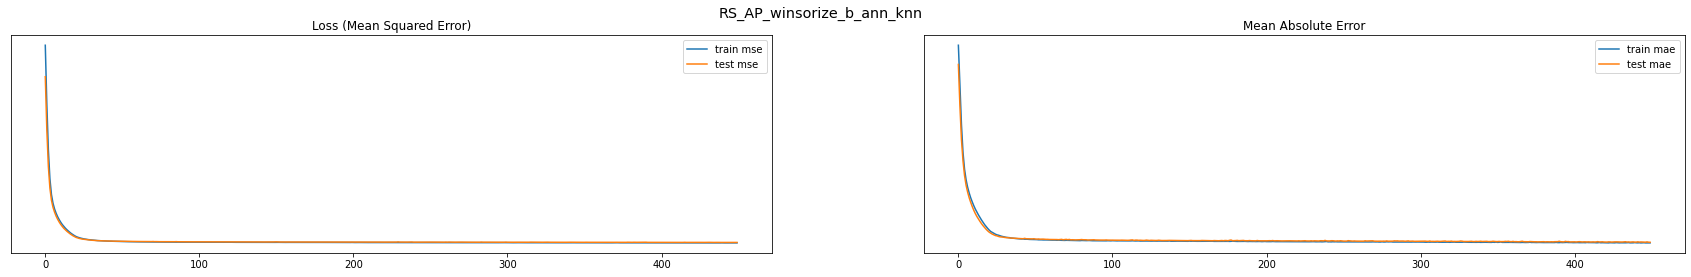

                               type  mean_squared_error  mean_absolute_error  \
0  train:_RS_AP_winsorize_b_ann_knn               17.23                3.215   
1   test:_RS_AP_winsorize_b_ann_knn               17.91                3.254   
2         RS_AP_winsorize_b_ann_knn                0.68                0.039   

   r2_score  e_v_score  
0    94.067     94.077  
1    93.891     93.897  
2     0.176      0.180  


In [ ]:
pipe_simple = define_pipeline_simple(RobustScaler())
X_train, X_test, y_train, y_test, pipe,  y_test_orig, y_train_orig = split_impute_scale_pipe (pp_dataset, pipe_simple, KNNImputer(n_neighbors=2), False, True)
complete_run ("RS_AP_winsorize_b_ann_knn", pipe)

In [ ]:
show_results(False)

,modelName,train_mse,test_mse,difference
1,base_ann,16.975,17.756,0.781
3,RS_RH_winsorize_b_ann_knn,16.943,17.777,0.834
4,RS_AP_winsorize_b_ann_knn,17.230,17.910,0.680
2,RS_RH_AP_winsorize_b_ann_knn,17.226,17.985,0.759
0,basemodel,21.448,22.164,0.716
,modelName,train_mae,test_mae,difference
1,base_ann,3.156,3.207,0.051
3,RS_RH_winsorize_b_ann_knn,3.185,3.245,0.061
4,RS_AP_winsorize_b_ann_knn,3.215,3.254,0.039
2,RS_RH_AP_winsorize_b_ann_knn,3.190,3.261,0.071


<Figure size 2880x1080 with 0 Axes>

## -normalize


Epoch 1: val_loss improved from inf to 0.30695, saving model to /content/drive/MyDrive/Colab Notebooks/4.ML_ANN_Project/weights_and_models/resnet-weights_RS_RH_AP_winsorize_RCPR_BC_ann_knn.hdf5

Epoch 2: val_loss improved from 0.30695 to 0.25207, saving model to /content/drive/MyDrive/Colab Notebooks/4.ML_ANN_Project/weights_and_models/resnet-weights_RS_RH_AP_winsorize_RCPR_BC_ann_knn.hdf5

Epoch 3: val_loss improved from 0.25207 to 0.19343, saving model to /content/drive/MyDrive/Colab Notebooks/4.ML_ANN_Project/weights_and_models/resnet-weights_RS_RH_AP_winsorize_RCPR_BC_ann_knn.hdf5

Epoch 4: val_loss improved from 0.19343 to 0.11890, saving model to /content/drive/MyDrive/Colab Notebooks/4.ML_ANN_Project/weights_and_models/resnet-weights_RS_RH_AP_winsorize_RCPR_BC_ann_knn.hdf5

Epoch 5: val_loss improved from 0.11890 to 0.06965, saving model to /content/drive/MyDrive/Colab Notebooks/4.ML_ANN_Project/weights_and_models/resnet-weights_RS_RH_AP_winsorize_RCPR_BC_ann_knn.hdf5

Epoch 6:

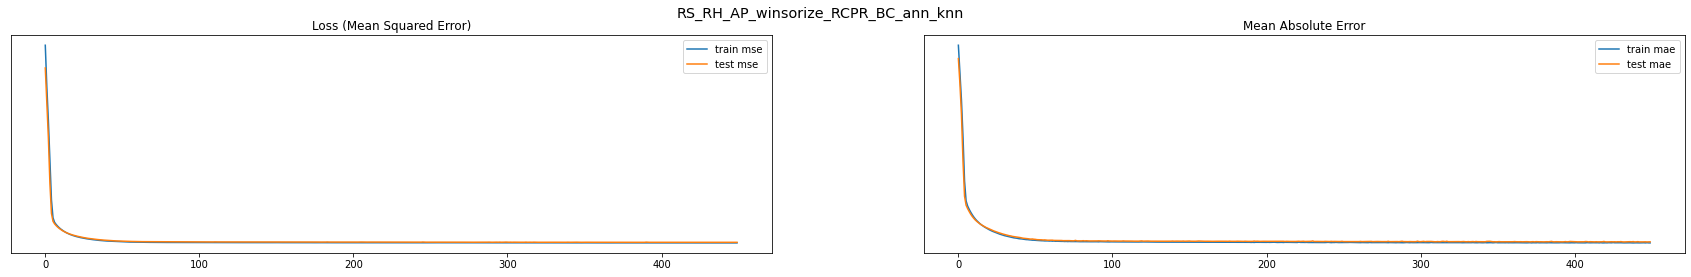

                                        type  mean_squared_error  \
0  train:_RS_RH_AP_winsorize_RCPR_BC_ann_knn              17.293   
1   test:_RS_RH_AP_winsorize_RCPR_BC_ann_knn              18.099   
2         RS_RH_AP_winsorize_RCPR_BC_ann_knn               0.806   

   mean_absolute_error  r2_score  e_v_score  
0                3.220    94.046     94.047  
1                3.282    93.826     93.830  
2                0.062     0.220      0.217  


ColumnTransformer(remainder=Pipeline(steps=[('scaler', RobustScaler())]),
                  transformers=[('RH_col',
                                 Pipeline(steps=[('transformer_step',
                                                  PowerTransformer(method='box-cox',
                                                                   standardize=False)),
                                                 ('scaler', RobustScaler())]),
                                 ['RH']),
                                ('AP_col',
                                 Pipeline(steps=[('preprocess_step',
                                                  FunctionTransformer(func=<function <lambda> at 0x7fd94b149af0>,
                                                                      validate=True)),
                                                 ('scaler', RobustScaler())]),
                                 ['AP'])])

In [ ]:
rcpr_transformer = FunctionTransformer(lambda x: 1/x, validate = True)
bc_transformer = PowerTransformer(method = 'box-cox', standardize = False)

pipe_complex = define_pipeline_complex(RobustScaler(),bc_transformer, rcpr_transformer)
X_train, X_test, y_train, y_test, pipe,  y_test_orig, y_train_orig = split_impute_scale_pipe (pp_dataset, pipe_complex, KNNImputer(n_neighbors=2), True, True)
complete_run ("RS_RH_AP_winsorize_RCPR_BC_ann_knn",pipe)
pipe_complex


Epoch 1: val_loss improved from inf to 0.18780, saving model to /content/drive/MyDrive/Colab Notebooks/4.ML_ANN_Project/weights_and_models/resnet-weights_RS_RH_AP_winsorize_RCPR_YJ_ann_knn.hdf5

Epoch 2: val_loss improved from 0.18780 to 0.13629, saving model to /content/drive/MyDrive/Colab Notebooks/4.ML_ANN_Project/weights_and_models/resnet-weights_RS_RH_AP_winsorize_RCPR_YJ_ann_knn.hdf5

Epoch 3: val_loss improved from 0.13629 to 0.10167, saving model to /content/drive/MyDrive/Colab Notebooks/4.ML_ANN_Project/weights_and_models/resnet-weights_RS_RH_AP_winsorize_RCPR_YJ_ann_knn.hdf5

Epoch 4: val_loss improved from 0.10167 to 0.07750, saving model to /content/drive/MyDrive/Colab Notebooks/4.ML_ANN_Project/weights_and_models/resnet-weights_RS_RH_AP_winsorize_RCPR_YJ_ann_knn.hdf5

Epoch 5: val_loss improved from 0.07750 to 0.06117, saving model to /content/drive/MyDrive/Colab Notebooks/4.ML_ANN_Project/weights_and_models/resnet-weights_RS_RH_AP_winsorize_RCPR_YJ_ann_knn.hdf5

Epoch 6:

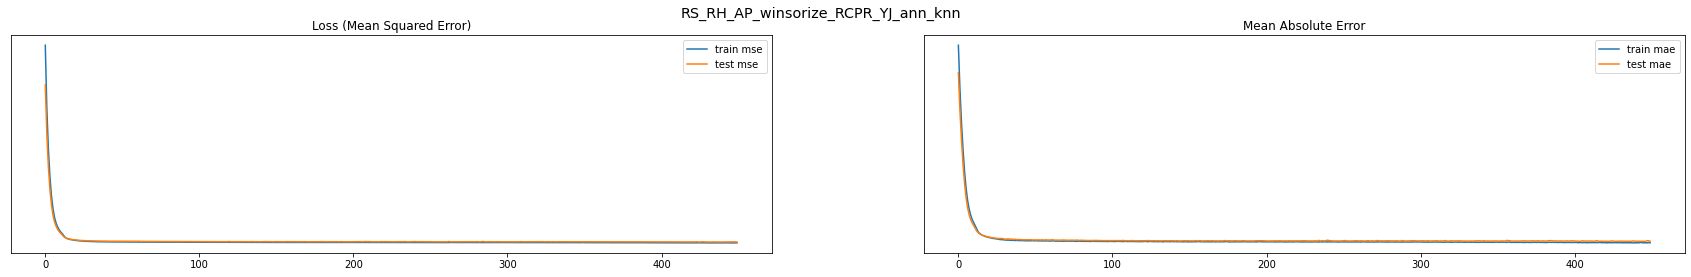

                                        type  mean_squared_error  \
0  train:_RS_RH_AP_winsorize_RCPR_YJ_ann_knn              17.001   
1   test:_RS_RH_AP_winsorize_RCPR_YJ_ann_knn              17.718   
2         RS_RH_AP_winsorize_RCPR_YJ_ann_knn               0.718   

   mean_absolute_error  r2_score  e_v_score  
0                 3.20    94.146     94.147  
1                 3.26    93.956     93.957  
2                 0.06     0.190      0.190  


ColumnTransformer(remainder=Pipeline(steps=[('scaler', RobustScaler())]),
                  transformers=[('RH_col',
                                 Pipeline(steps=[('transformer_step',
                                                  PowerTransformer(standardize=False)),
                                                 ('scaler', RobustScaler())]),
                                 ['RH']),
                                ('AP_col',
                                 Pipeline(steps=[('preprocess_step',
                                                  FunctionTransformer(func=<function <lambda> at 0x7fd94a974a60>,
                                                                      validate=True)),
                                                 ('scaler', RobustScaler())]),
                                 ['AP'])])

In [ ]:
rcpr_transformer = FunctionTransformer(lambda x: 1/x, validate = True)
yj_transformer = PowerTransformer(method = 'yeo-johnson', standardize = False)

pipe_complex = define_pipeline_complex(RobustScaler(),yj_transformer, rcpr_transformer)
X_train, X_test, y_train, y_test, pipe,  y_test_orig, y_train_orig = split_impute_scale_pipe (pp_dataset, pipe_complex, KNNImputer(n_neighbors=2), True, True)
complete_run ("RS_RH_AP_winsorize_RCPR_YJ_ann_knn",pipe)
pipe_complex


Epoch 1: val_loss improved from inf to 0.52898, saving model to /content/drive/MyDrive/Colab Notebooks/4.ML_ANN_Project/weights_and_models/resnet-weights_RS_RH_AP_winsorize_RCPR_na_ann_knn.hdf5

Epoch 2: val_loss improved from 0.52898 to 0.40870, saving model to /content/drive/MyDrive/Colab Notebooks/4.ML_ANN_Project/weights_and_models/resnet-weights_RS_RH_AP_winsorize_RCPR_na_ann_knn.hdf5

Epoch 3: val_loss improved from 0.40870 to 0.32667, saving model to /content/drive/MyDrive/Colab Notebooks/4.ML_ANN_Project/weights_and_models/resnet-weights_RS_RH_AP_winsorize_RCPR_na_ann_knn.hdf5

Epoch 4: val_loss improved from 0.32667 to 0.27211, saving model to /content/drive/MyDrive/Colab Notebooks/4.ML_ANN_Project/weights_and_models/resnet-weights_RS_RH_AP_winsorize_RCPR_na_ann_knn.hdf5

Epoch 5: val_loss improved from 0.27211 to 0.23569, saving model to /content/drive/MyDrive/Colab Notebooks/4.ML_ANN_Project/weights_and_models/resnet-weights_RS_RH_AP_winsorize_RCPR_na_ann_knn.hdf5

Epoch 6:

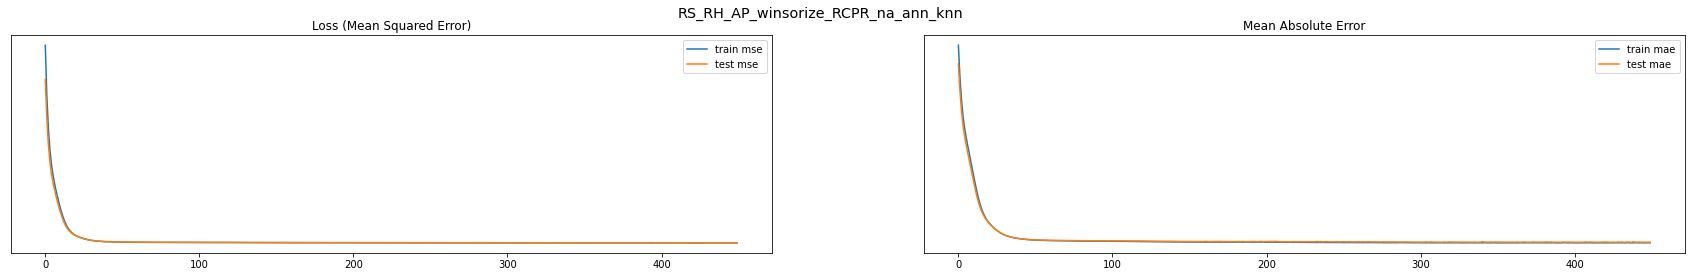

                                        type  mean_squared_error  \
0  train:_RS_RH_AP_winsorize_RCPR_na_ann_knn              16.928   
1   test:_RS_RH_AP_winsorize_RCPR_na_ann_knn              17.442   
2         RS_RH_AP_winsorize_RCPR_na_ann_knn               0.514   

   mean_absolute_error  r2_score  e_v_score  
0                3.180    94.172     94.172  
1                3.231    94.050     94.052  
2                0.051     0.122      0.120  


ColumnTransformer(remainder=Pipeline(steps=[('scaler', RobustScaler())]),
                  transformers=[('RH_col',
                                 Pipeline(steps=[('scaler', RobustScaler())]),
                                 ['RH']),
                                ('AP_col',
                                 Pipeline(steps=[('preprocess_step',
                                                  FunctionTransformer(func=<function <lambda> at 0x7fd958423ee0>,
                                                                      validate=True)),
                                                 ('scaler', RobustScaler())]),
                                 ['AP'])])

In [ ]:
rcpr_transformer = FunctionTransformer(lambda x: 1/x, validate = True)
yj_transformer = PowerTransformer(method = 'yeo-johnson', standardize = False)

pipe_complex = define_pipeline_complex(RobustScaler(),yj_transformer, rcpr_transformer, False, True)
X_train, X_test, y_train, y_test, pipe,  y_test_orig, y_train_orig = split_impute_scale_pipe (pp_dataset, pipe_complex, KNNImputer(n_neighbors=2), True, True)
complete_run ("RS_RH_AP_winsorize_RCPR_na_ann_knn",pipe)
pipe_complex


Epoch 1: val_loss improved from inf to 0.32072, saving model to /content/drive/MyDrive/Colab Notebooks/4.ML_ANN_Project/weights_and_models/resnet-weights_RS_RH_AP_winsorize_na_YJ_ann_knn.hdf5

Epoch 2: val_loss improved from 0.32072 to 0.24730, saving model to /content/drive/MyDrive/Colab Notebooks/4.ML_ANN_Project/weights_and_models/resnet-weights_RS_RH_AP_winsorize_na_YJ_ann_knn.hdf5

Epoch 3: val_loss improved from 0.24730 to 0.19199, saving model to /content/drive/MyDrive/Colab Notebooks/4.ML_ANN_Project/weights_and_models/resnet-weights_RS_RH_AP_winsorize_na_YJ_ann_knn.hdf5

Epoch 4: val_loss improved from 0.19199 to 0.14963, saving model to /content/drive/MyDrive/Colab Notebooks/4.ML_ANN_Project/weights_and_models/resnet-weights_RS_RH_AP_winsorize_na_YJ_ann_knn.hdf5

Epoch 5: val_loss improved from 0.14963 to 0.12412, saving model to /content/drive/MyDrive/Colab Notebooks/4.ML_ANN_Project/weights_and_models/resnet-weights_RS_RH_AP_winsorize_na_YJ_ann_knn.hdf5

Epoch 6: val_loss 

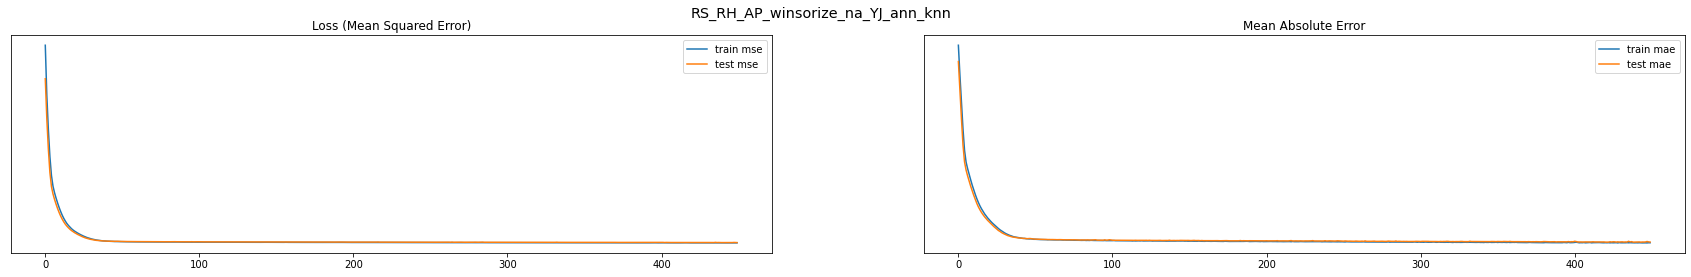

                                      type  mean_squared_error  \
0  train:_RS_RH_AP_winsorize_na_YJ_ann_knn              17.025   
1   test:_RS_RH_AP_winsorize_na_YJ_ann_knn              17.550   
2         RS_RH_AP_winsorize_na_YJ_ann_knn               0.525   

   mean_absolute_error  r2_score  e_v_score  
0                3.183    94.138     94.141  
1                3.231    94.014     94.016  
2                0.048     0.124      0.125  


ColumnTransformer(remainder=Pipeline(steps=[('scaler', RobustScaler())]),
                  transformers=[('RH_col',
                                 Pipeline(steps=[('transformer_step',
                                                  PowerTransformer(standardize=False)),
                                                 ('scaler', RobustScaler())]),
                                 ['RH']),
                                ('AP_col',
                                 Pipeline(steps=[('scaler', RobustScaler())]),
                                 ['AP'])])

In [ ]:
rcpr_transformer = FunctionTransformer(lambda x: 1/x, validate = True)
yj_transformer = PowerTransformer(method = 'yeo-johnson', standardize = False)

pipe_complex = define_pipeline_complex(RobustScaler(),yj_transformer, rcpr_transformer, True, False)
X_train, X_test, y_train, y_test, pipe,  y_test_orig, y_train_orig = split_impute_scale_pipe (pp_dataset, pipe_complex, KNNImputer(n_neighbors=2), True, True)
complete_run ("RS_RH_AP_winsorize_na_YJ_ann_knn",pipe)
pipe_complex


Epoch 1: val_loss improved from inf to 0.20677, saving model to /content/drive/MyDrive/Colab Notebooks/4.ML_ANN_Project/weights_and_models/resnet-weights_RS_RH_AP_winsorize_na_BC_ann_knn.hdf5

Epoch 2: val_loss improved from 0.20677 to 0.15500, saving model to /content/drive/MyDrive/Colab Notebooks/4.ML_ANN_Project/weights_and_models/resnet-weights_RS_RH_AP_winsorize_na_BC_ann_knn.hdf5

Epoch 3: val_loss improved from 0.15500 to 0.12056, saving model to /content/drive/MyDrive/Colab Notebooks/4.ML_ANN_Project/weights_and_models/resnet-weights_RS_RH_AP_winsorize_na_BC_ann_knn.hdf5

Epoch 4: val_loss improved from 0.12056 to 0.09511, saving model to /content/drive/MyDrive/Colab Notebooks/4.ML_ANN_Project/weights_and_models/resnet-weights_RS_RH_AP_winsorize_na_BC_ann_knn.hdf5

Epoch 5: val_loss improved from 0.09511 to 0.07717, saving model to /content/drive/MyDrive/Colab Notebooks/4.ML_ANN_Project/weights_and_models/resnet-weights_RS_RH_AP_winsorize_na_BC_ann_knn.hdf5

Epoch 6: val_loss 

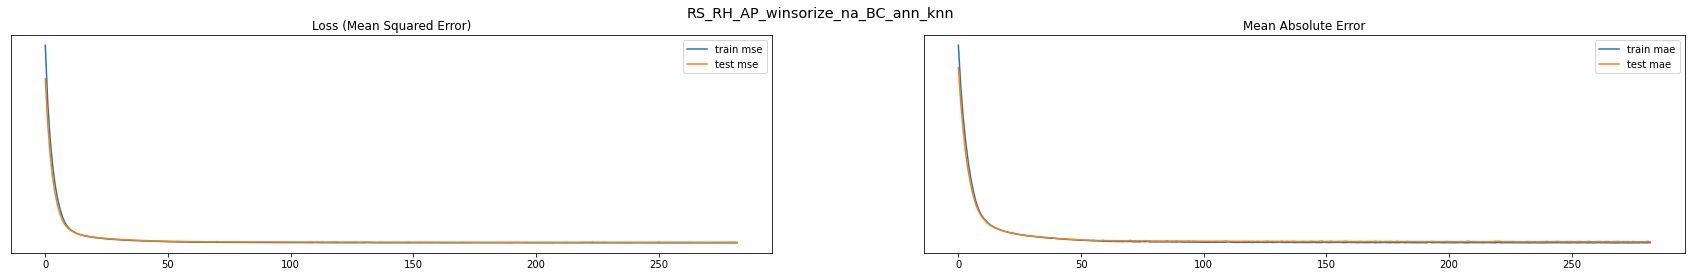

                                      type  mean_squared_error  \
0  train:_RS_RH_AP_winsorize_na_BC_ann_knn              17.490   
1   test:_RS_RH_AP_winsorize_na_BC_ann_knn              18.111   
2         RS_RH_AP_winsorize_na_BC_ann_knn               0.621   

   mean_absolute_error  r2_score  e_v_score  
0                3.249    93.978     93.981  
1                3.301    93.822     93.824  
2                0.052     0.156      0.157  


ColumnTransformer(remainder=Pipeline(steps=[('scaler', RobustScaler())]),
                  transformers=[('RH_col',
                                 Pipeline(steps=[('transformer_step',
                                                  PowerTransformer(method='box-cox',
                                                                   standardize=False)),
                                                 ('scaler', RobustScaler())]),
                                 ['RH']),
                                ('AP_col',
                                 Pipeline(steps=[('scaler', RobustScaler())]),
                                 ['AP'])])

In [ ]:
rcpr_transformer = FunctionTransformer(lambda x: 1/x, validate = True)
bc_transformer = PowerTransformer(method = 'box-cox', standardize = False)

pipe_complex = define_pipeline_complex(RobustScaler(),bc_transformer, rcpr_transformer, True, False)
X_train, X_test, y_train, y_test, pipe,  y_test_orig, y_train_orig = split_impute_scale_pipe (pp_dataset, pipe_complex, KNNImputer(n_neighbors=2), True, True)
complete_run ("RS_RH_AP_winsorize_na_BC_ann_knn",pipe)
pipe_complex

In [ ]:
show_results(False)

,modelName,train_mse,test_mse,difference
7,RS_RH_AP_winsorize_RCPR_na_ann_knn,16.928,17.442,0.514
8,RS_RH_AP_winsorize_na_YJ_ann_knn,17.025,17.550,0.525
6,RS_RH_AP_winsorize_RCPR_YJ_ann_knn,17.001,17.718,0.718
1,base_ann,16.975,17.756,0.781
3,RS_RH_winsorize_b_ann_knn,16.943,17.777,0.834
4,RS_AP_winsorize_b_ann_knn,17.230,17.910,0.680
2,RS_RH_AP_winsorize_b_ann_knn,17.226,17.985,0.759
5,RS_RH_AP_winsorize_RCPR_BC_ann_knn,17.293,18.099,0.806
9,RS_RH_AP_winsorize_na_BC_ann_knn,17.490,18.111,0.621
0,basemodel,21.448,22.164,0.716


<Figure size 2880x1080 with 0 Axes>

It can be seen that model with with both AP and RH winzorized and normalised shows best results, but model with only winzorised variables is more stable and overfits less furthermore the differentce of optimal model and models with bestresults is small and can be neglected.

The latter modification will be developed further

# 3.ANN model tuning

## 3.1 Modifying model architecture in combination with optimizers

### Adam optimizer


Epoch 1: val_loss improved from inf to 0.23588, saving model to /content/drive/MyDrive/Colab Notebooks/4.ML_ANN_Project/weights_and_models/resnet-weights_No3.1.1_Adam_layers:_2_units:_6.hdf5

Epoch 2: val_loss improved from 0.23588 to 0.18359, saving model to /content/drive/MyDrive/Colab Notebooks/4.ML_ANN_Project/weights_and_models/resnet-weights_No3.1.1_Adam_layers:_2_units:_6.hdf5

Epoch 3: val_loss improved from 0.18359 to 0.14443, saving model to /content/drive/MyDrive/Colab Notebooks/4.ML_ANN_Project/weights_and_models/resnet-weights_No3.1.1_Adam_layers:_2_units:_6.hdf5

Epoch 4: val_loss improved from 0.14443 to 0.11694, saving model to /content/drive/MyDrive/Colab Notebooks/4.ML_ANN_Project/weights_and_models/resnet-weights_No3.1.1_Adam_layers:_2_units:_6.hdf5

Epoch 5: val_loss improved from 0.11694 to 0.09808, saving model to /content/drive/MyDrive/Colab Notebooks/4.ML_ANN_Project/weights_and_models/resnet-weights_No3.1.1_Adam_layers:_2_units:_6.hdf5

Epoch 6: val_loss impro

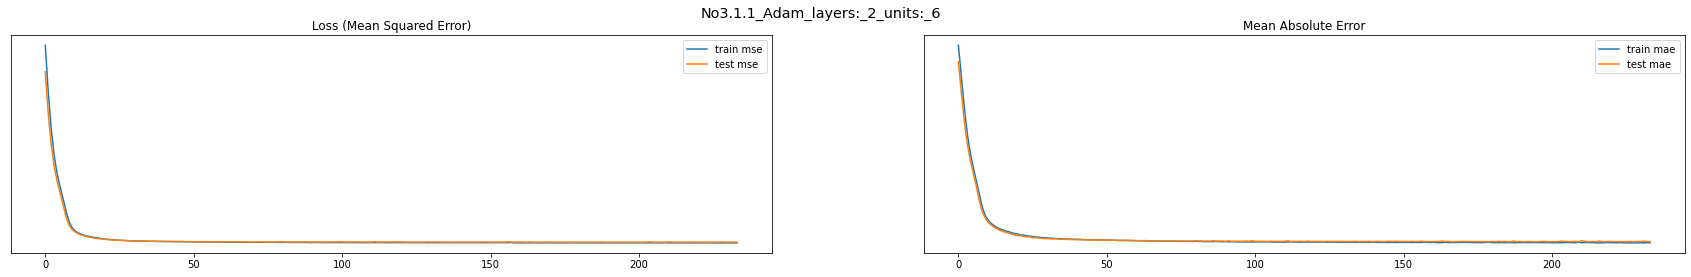

                                     type  mean_squared_error  \
0  train:_No3.1.1_Adam_layers:_2_units:_6              16.607   
1   test:_No3.1.1_Adam_layers:_2_units:_6              17.428   
2         No3.1.1_Adam_layers:_2_units:_6               0.821   

   mean_absolute_error  r2_score  e_v_score  
0                3.145    94.282     94.297  
1                3.209    94.055     94.071  
2                0.064     0.227      0.226  

Epoch 1: val_loss improved from inf to 0.31508, saving model to /content/drive/MyDrive/Colab Notebooks/4.ML_ANN_Project/weights_and_models/resnet-weights_No3.1.1_Adam_layers:_2_units:_8.hdf5

Epoch 2: val_loss improved from 0.31508 to 0.20265, saving model to /content/drive/MyDrive/Colab Notebooks/4.ML_ANN_Project/weights_and_models/resnet-weights_No3.1.1_Adam_layers:_2_units:_8.hdf5

Epoch 3: val_loss improved from 0.20265 to 0.14796, saving model to /content/drive/MyDrive/Colab Notebooks/4.ML_ANN_Project/weights_and_models/resnet-weights_No3.1.1_

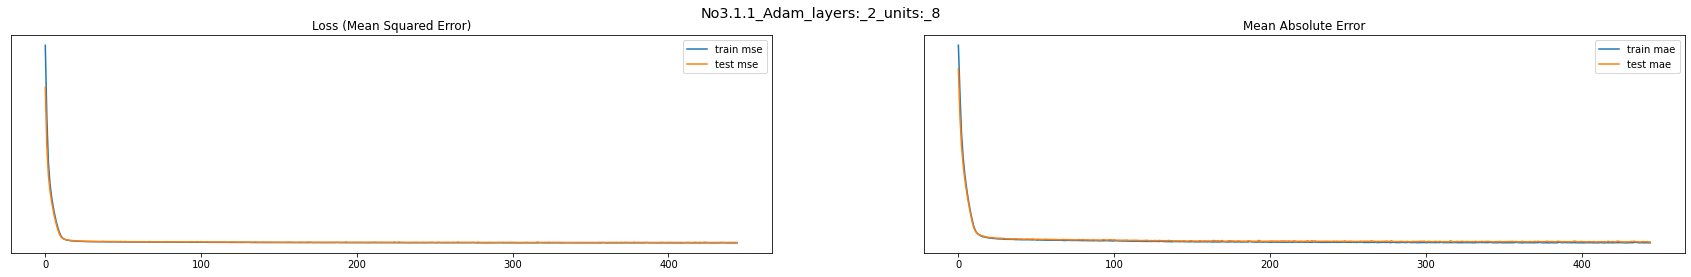

                                     type  mean_squared_error  \
0  train:_No3.1.1_Adam_layers:_2_units:_8              16.201   
1   test:_No3.1.1_Adam_layers:_2_units:_8              16.923   
2         No3.1.1_Adam_layers:_2_units:_8               0.723   

   mean_absolute_error  r2_score  e_v_score  
0                3.085    94.422     94.424  
1                3.158    94.227     94.232  
2                0.072     0.195      0.192  

Epoch 1: val_loss improved from inf to 0.16389, saving model to /content/drive/MyDrive/Colab Notebooks/4.ML_ANN_Project/weights_and_models/resnet-weights_No3.1.1_Adam_layers:_2_units:_16.hdf5

Epoch 2: val_loss improved from 0.16389 to 0.06130, saving model to /content/drive/MyDrive/Colab Notebooks/4.ML_ANN_Project/weights_and_models/resnet-weights_No3.1.1_Adam_layers:_2_units:_16.hdf5

Epoch 3: val_loss improved from 0.06130 to 0.03765, saving model to /content/drive/MyDrive/Colab Notebooks/4.ML_ANN_Project/weights_and_models/resnet-weights_No3.1.

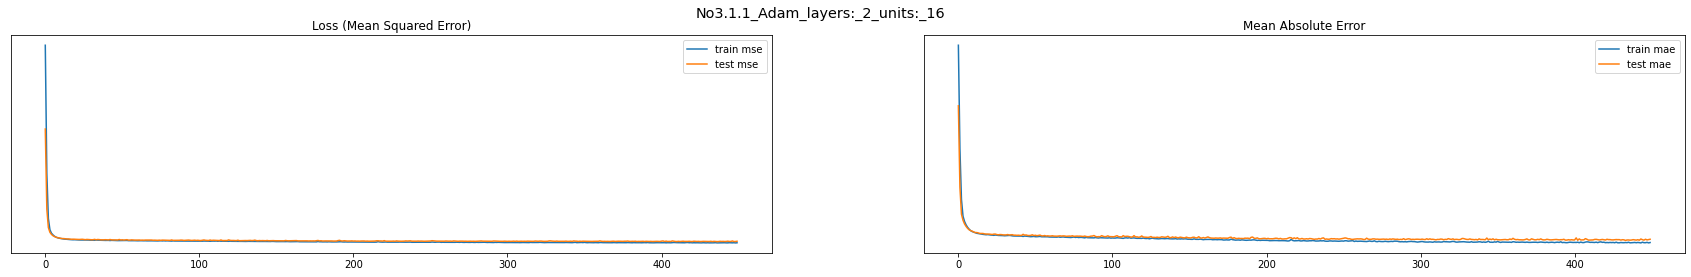

                                      type  mean_squared_error  \
0  train:_No3.1.1_Adam_layers:_2_units:_16              14.638   
1   test:_No3.1.1_Adam_layers:_2_units:_16              16.163   
2         No3.1.1_Adam_layers:_2_units:_16               1.525   

   mean_absolute_error  r2_score  e_v_score  
0                2.910    94.960     95.035  
1                3.044    94.487     94.566  
2                0.134     0.473      0.469  

Epoch 1: val_loss improved from inf to 0.13888, saving model to /content/drive/MyDrive/Colab Notebooks/4.ML_ANN_Project/weights_and_models/resnet-weights_No3.1.1_Adam_layers:_2_units:_32.hdf5

Epoch 2: val_loss improved from 0.13888 to 0.03737, saving model to /content/drive/MyDrive/Colab Notebooks/4.ML_ANN_Project/weights_and_models/resnet-weights_No3.1.1_Adam_layers:_2_units:_32.hdf5

Epoch 3: val_loss improved from 0.03737 to 0.02779, saving model to /content/drive/MyDrive/Colab Notebooks/4.ML_ANN_Project/weights_and_models/resnet-weights_No

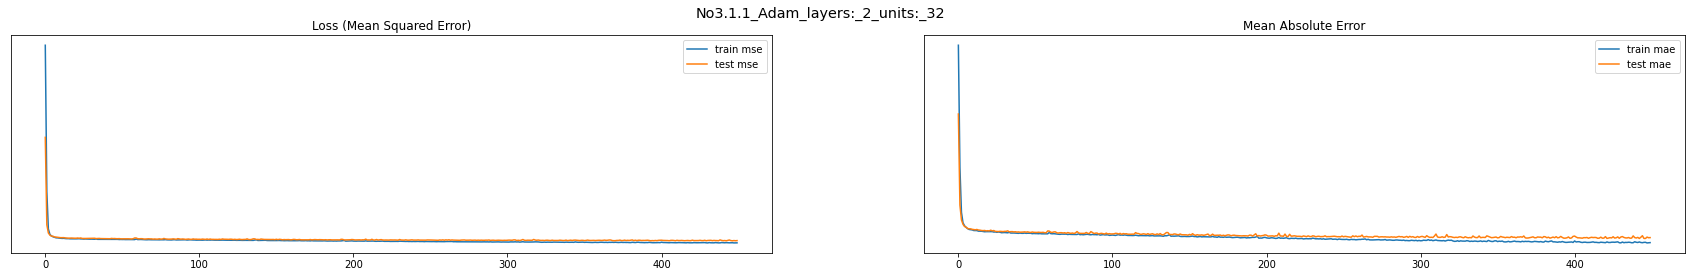

                                      type  mean_squared_error  \
0  train:_No3.1.1_Adam_layers:_2_units:_32              12.987   
1   test:_No3.1.1_Adam_layers:_2_units:_32              15.232   
2         No3.1.1_Adam_layers:_2_units:_32               2.245   

   mean_absolute_error  r2_score  e_v_score  
0                2.699    95.528     95.567  
1                2.915    94.804     94.847  
2                0.216     0.724      0.720  

Epoch 1: val_loss improved from inf to 0.03516, saving model to /content/drive/MyDrive/Colab Notebooks/4.ML_ANN_Project/weights_and_models/resnet-weights_No3.1.1_Adam_layers:_2_units:_64.hdf5

Epoch 2: val_loss improved from 0.03516 to 0.02420, saving model to /content/drive/MyDrive/Colab Notebooks/4.ML_ANN_Project/weights_and_models/resnet-weights_No3.1.1_Adam_layers:_2_units:_64.hdf5

Epoch 3: val_loss improved from 0.02420 to 0.02355, saving model to /content/drive/MyDrive/Colab Notebooks/4.ML_ANN_Project/weights_and_models/resnet-weights_No

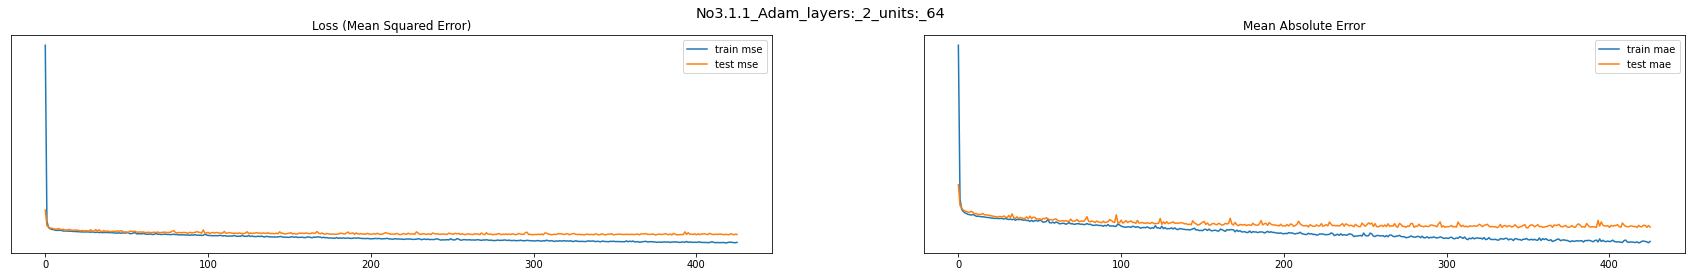

                                      type  mean_squared_error  \
0  train:_No3.1.1_Adam_layers:_2_units:_64               9.685   
1   test:_No3.1.1_Adam_layers:_2_units:_64              14.592   
2         No3.1.1_Adam_layers:_2_units:_64               4.906   

   mean_absolute_error  r2_score  e_v_score  
0                2.254    96.665     96.667  
1                2.788    95.023     95.025  
2                0.534     1.642      1.642  

Epoch 1: val_loss improved from inf to 0.29416, saving model to /content/drive/MyDrive/Colab Notebooks/4.ML_ANN_Project/weights_and_models/resnet-weights_No3.1.1_Adam_layers:_4_units:_6.hdf5

Epoch 2: val_loss improved from 0.29416 to 0.25596, saving model to /content/drive/MyDrive/Colab Notebooks/4.ML_ANN_Project/weights_and_models/resnet-weights_No3.1.1_Adam_layers:_4_units:_6.hdf5

Epoch 3: val_loss improved from 0.25596 to 0.23202, saving model to /content/drive/MyDrive/Colab Notebooks/4.ML_ANN_Project/weights_and_models/resnet-weights_No3.

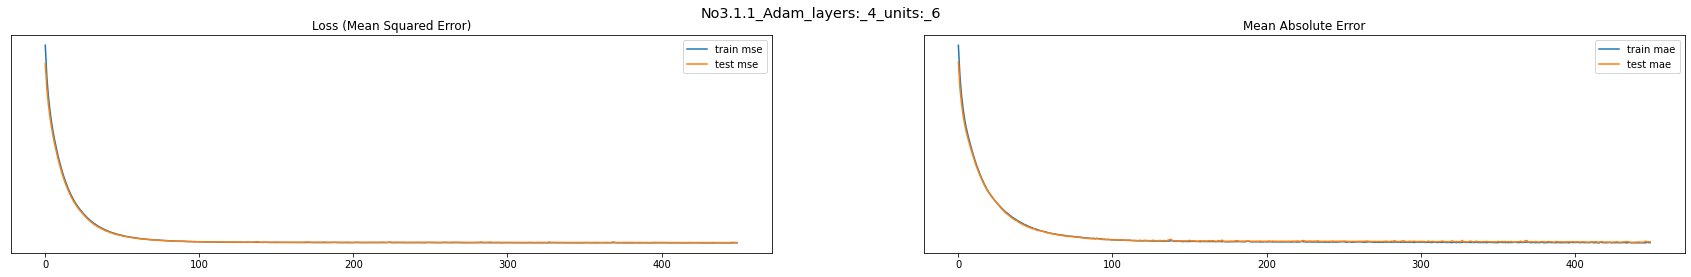

                                     type  mean_squared_error  \
0  train:_No3.1.1_Adam_layers:_4_units:_6              16.801   
1   test:_No3.1.1_Adam_layers:_4_units:_6              17.176   
2         No3.1.1_Adam_layers:_4_units:_6               0.375   

   mean_absolute_error  r2_score  e_v_score  
0                3.173    94.215     94.224  
1                3.200    94.141     94.148  
2                0.028     0.074      0.076  

Epoch 1: val_loss improved from inf to 0.33846, saving model to /content/drive/MyDrive/Colab Notebooks/4.ML_ANN_Project/weights_and_models/resnet-weights_No3.1.1_Adam_layers:_4_units:_8.hdf5

Epoch 2: val_loss improved from 0.33846 to 0.26832, saving model to /content/drive/MyDrive/Colab Notebooks/4.ML_ANN_Project/weights_and_models/resnet-weights_No3.1.1_Adam_layers:_4_units:_8.hdf5

Epoch 3: val_loss improved from 0.26832 to 0.20408, saving model to /content/drive/MyDrive/Colab Notebooks/4.ML_ANN_Project/weights_and_models/resnet-weights_No3.1.1_

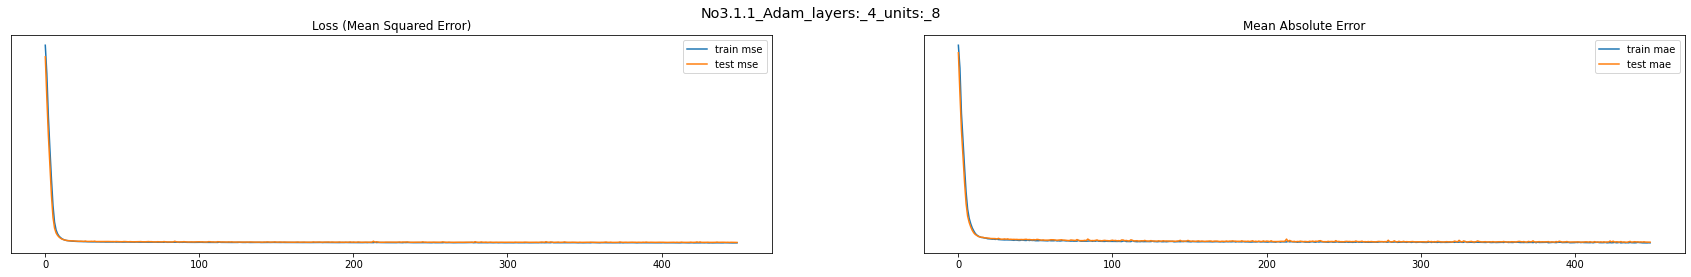

                                     type  mean_squared_error  \
0  train:_No3.1.1_Adam_layers:_4_units:_8              16.036   
1   test:_No3.1.1_Adam_layers:_4_units:_8              16.767   
2         No3.1.1_Adam_layers:_4_units:_8               0.732   

   mean_absolute_error  r2_score  e_v_score  
0                3.086    94.479     94.479  
1                3.125    94.280     94.280  
2                0.039     0.199      0.199  

Epoch 1: val_loss improved from inf to 0.23861, saving model to /content/drive/MyDrive/Colab Notebooks/4.ML_ANN_Project/weights_and_models/resnet-weights_No3.1.1_Adam_layers:_4_units:_16.hdf5

Epoch 2: val_loss improved from 0.23861 to 0.04595, saving model to /content/drive/MyDrive/Colab Notebooks/4.ML_ANN_Project/weights_and_models/resnet-weights_No3.1.1_Adam_layers:_4_units:_16.hdf5

Epoch 3: val_loss improved from 0.04595 to 0.03068, saving model to /content/drive/MyDrive/Colab Notebooks/4.ML_ANN_Project/weights_and_models/resnet-weights_No3.1.

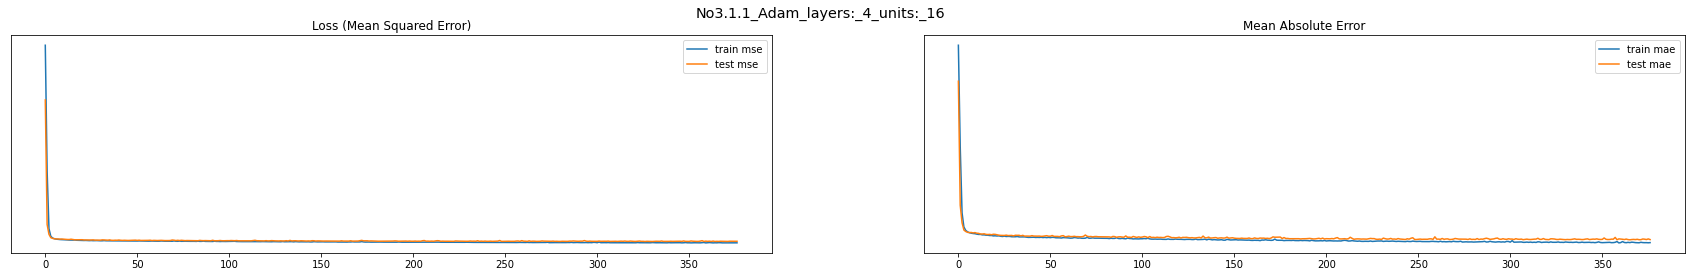

                                      type  mean_squared_error  \
0  train:_No3.1.1_Adam_layers:_4_units:_16              13.863   
1   test:_No3.1.1_Adam_layers:_4_units:_16              16.013   
2         No3.1.1_Adam_layers:_4_units:_16               2.150   

   mean_absolute_error  r2_score  e_v_score  
0                2.791    95.227     95.254  
1                3.000    94.538     94.567  
2                0.209     0.689      0.687  

Epoch 1: val_loss improved from inf to 0.13812, saving model to /content/drive/MyDrive/Colab Notebooks/4.ML_ANN_Project/weights_and_models/resnet-weights_No3.1.1_Adam_layers:_4_units:_32.hdf5

Epoch 2: val_loss improved from 0.13812 to 0.03217, saving model to /content/drive/MyDrive/Colab Notebooks/4.ML_ANN_Project/weights_and_models/resnet-weights_No3.1.1_Adam_layers:_4_units:_32.hdf5

Epoch 3: val_loss improved from 0.03217 to 0.02580, saving model to /content/drive/MyDrive/Colab Notebooks/4.ML_ANN_Project/weights_and_models/resnet-weights_No

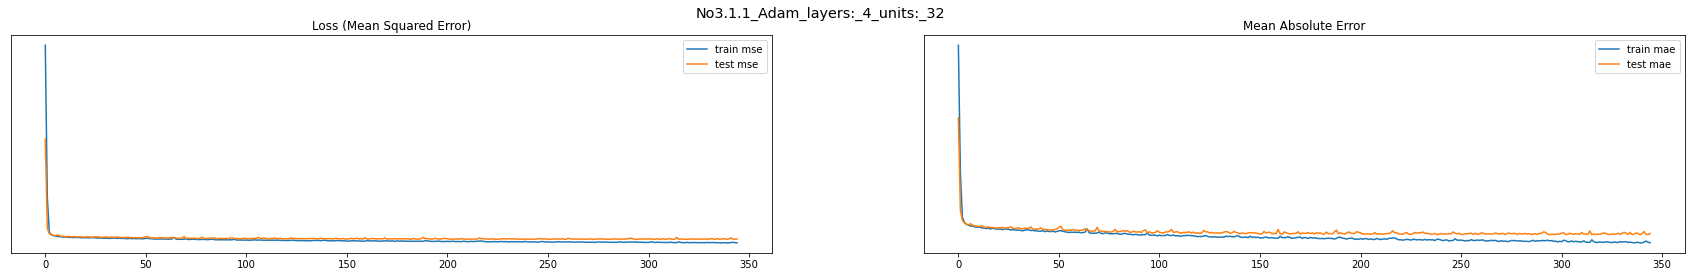

                                      type  mean_squared_error  \
0  train:_No3.1.1_Adam_layers:_4_units:_32              11.888   
1   test:_No3.1.1_Adam_layers:_4_units:_32              15.628   
2         No3.1.1_Adam_layers:_4_units:_32               3.740   

   mean_absolute_error  r2_score  e_v_score  
0                2.553    95.907     96.001  
1                2.954    94.669     94.770  
2                0.401     1.238      1.231  

Epoch 1: val_loss improved from inf to 0.03395, saving model to /content/drive/MyDrive/Colab Notebooks/4.ML_ANN_Project/weights_and_models/resnet-weights_No3.1.1_Adam_layers:_4_units:_64.hdf5

Epoch 2: val_loss improved from 0.03395 to 0.02453, saving model to /content/drive/MyDrive/Colab Notebooks/4.ML_ANN_Project/weights_and_models/resnet-weights_No3.1.1_Adam_layers:_4_units:_64.hdf5

Epoch 3: val_loss improved from 0.02453 to 0.02378, saving model to /content/drive/MyDrive/Colab Notebooks/4.ML_ANN_Project/weights_and_models/resnet-weights_No

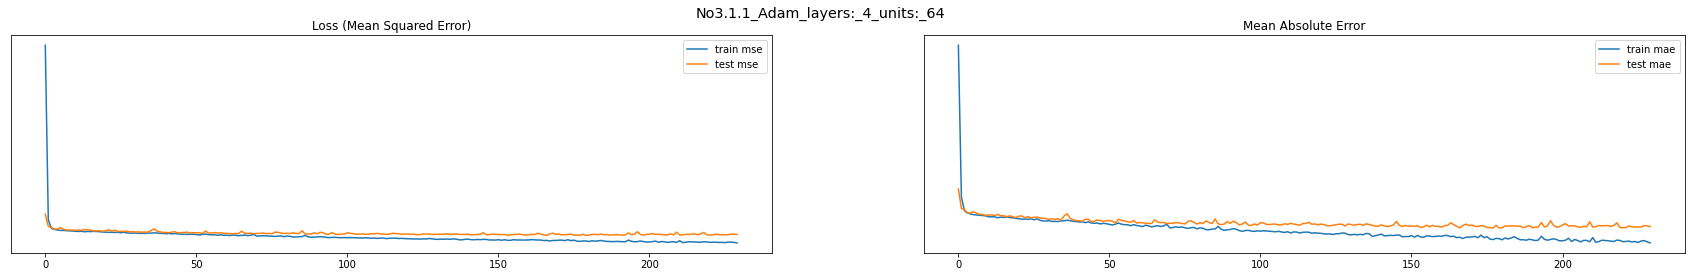

                                      type  mean_squared_error  \
0  train:_No3.1.1_Adam_layers:_4_units:_64               9.433   
1   test:_No3.1.1_Adam_layers:_4_units:_64              14.784   
2         No3.1.1_Adam_layers:_4_units:_64               5.350   

   mean_absolute_error  r2_score  e_v_score  
0                2.244    96.752     96.884  
1                2.809    94.957     95.098  
2                0.564     1.795      1.786  

Epoch 1: val_loss improved from inf to 0.26162, saving model to /content/drive/MyDrive/Colab Notebooks/4.ML_ANN_Project/weights_and_models/resnet-weights_No3.1.1_Adam_layers:_6_units:_6.hdf5

Epoch 2: val_loss improved from 0.26162 to 0.21868, saving model to /content/drive/MyDrive/Colab Notebooks/4.ML_ANN_Project/weights_and_models/resnet-weights_No3.1.1_Adam_layers:_6_units:_6.hdf5

Epoch 3: val_loss improved from 0.21868 to 0.17041, saving model to /content/drive/MyDrive/Colab Notebooks/4.ML_ANN_Project/weights_and_models/resnet-weights_No3.

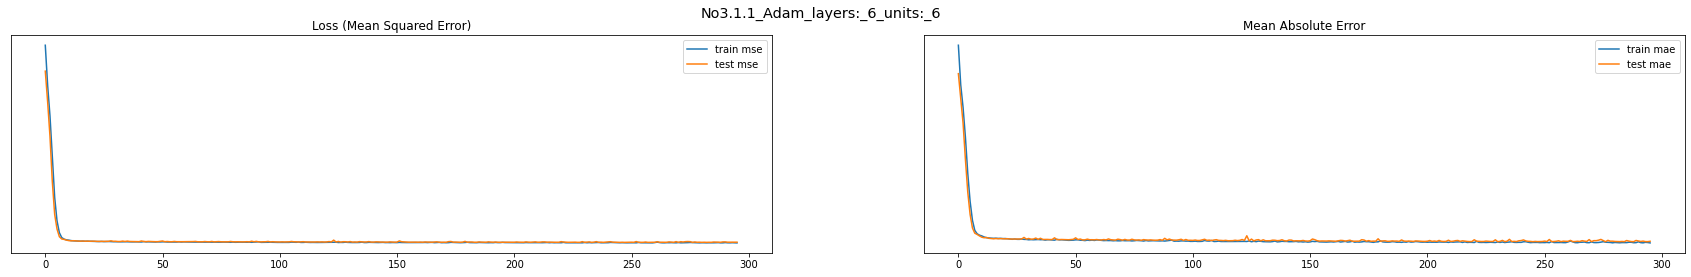

                                     type  mean_squared_error  \
0  train:_No3.1.1_Adam_layers:_6_units:_6              17.113   
1   test:_No3.1.1_Adam_layers:_6_units:_6              17.800   
2         No3.1.1_Adam_layers:_6_units:_6               0.687   

   mean_absolute_error  r2_score  e_v_score  
0                3.194    94.108     94.168  
1                3.255    93.928     93.986  
2                0.061     0.180      0.182  

Epoch 1: val_loss improved from inf to 0.34701, saving model to /content/drive/MyDrive/Colab Notebooks/4.ML_ANN_Project/weights_and_models/resnet-weights_No3.1.1_Adam_layers:_6_units:_8.hdf5

Epoch 2: val_loss improved from 0.34701 to 0.29095, saving model to /content/drive/MyDrive/Colab Notebooks/4.ML_ANN_Project/weights_and_models/resnet-weights_No3.1.1_Adam_layers:_6_units:_8.hdf5

Epoch 3: val_loss improved from 0.29095 to 0.16268, saving model to /content/drive/MyDrive/Colab Notebooks/4.ML_ANN_Project/weights_and_models/resnet-weights_No3.1.1_

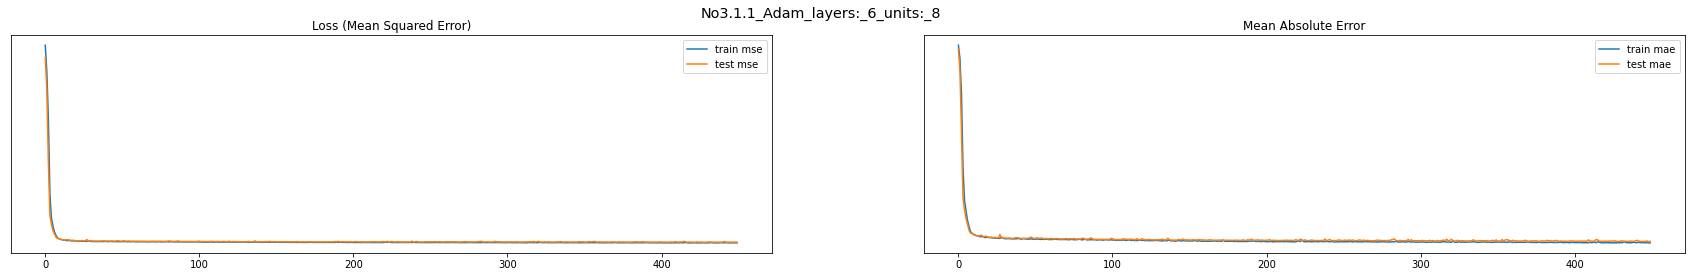

                                     type  mean_squared_error  \
0  train:_No3.1.1_Adam_layers:_6_units:_8              16.211   
1   test:_No3.1.1_Adam_layers:_6_units:_8              17.249   
2         No3.1.1_Adam_layers:_6_units:_8               1.038   

   mean_absolute_error  r2_score  e_v_score  
0                3.085    94.418     94.455  
1                3.177    94.116     94.150  
2                0.092     0.302      0.305  

Epoch 1: val_loss improved from inf to 0.28528, saving model to /content/drive/MyDrive/Colab Notebooks/4.ML_ANN_Project/weights_and_models/resnet-weights_No3.1.1_Adam_layers:_6_units:_16.hdf5

Epoch 2: val_loss improved from 0.28528 to 0.06840, saving model to /content/drive/MyDrive/Colab Notebooks/4.ML_ANN_Project/weights_and_models/resnet-weights_No3.1.1_Adam_layers:_6_units:_16.hdf5

Epoch 3: val_loss improved from 0.06840 to 0.03877, saving model to /content/drive/MyDrive/Colab Notebooks/4.ML_ANN_Project/weights_and_models/resnet-weights_No3.1.

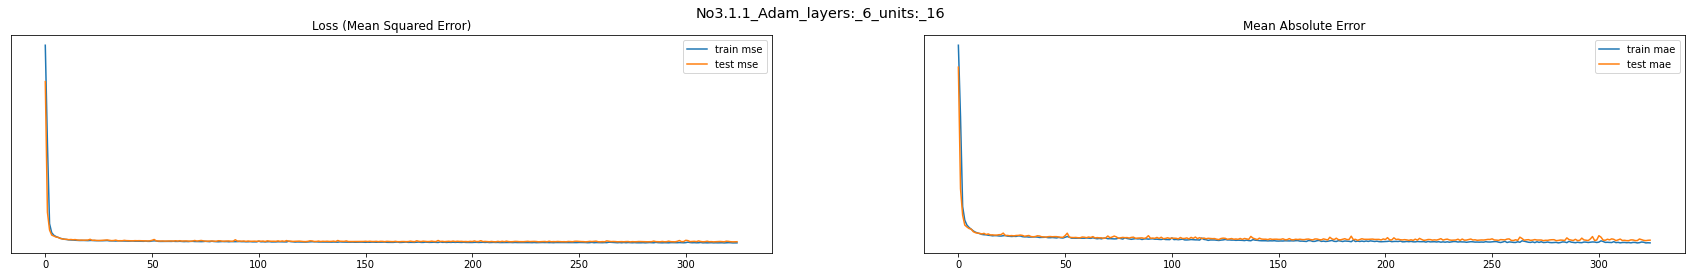

                                      type  mean_squared_error  \
0  train:_No3.1.1_Adam_layers:_6_units:_16              13.874   
1   test:_No3.1.1_Adam_layers:_6_units:_16              15.533   
2         No3.1.1_Adam_layers:_6_units:_16               1.658   

   mean_absolute_error  r2_score  e_v_score  
0                2.790    95.223     95.267  
1                2.947    94.702     94.741  
2                0.157     0.521      0.526  

Epoch 1: val_loss improved from inf to 0.04627, saving model to /content/drive/MyDrive/Colab Notebooks/4.ML_ANN_Project/weights_and_models/resnet-weights_No3.1.1_Adam_layers:_6_units:_32.hdf5

Epoch 2: val_loss improved from 0.04627 to 0.02912, saving model to /content/drive/MyDrive/Colab Notebooks/4.ML_ANN_Project/weights_and_models/resnet-weights_No3.1.1_Adam_layers:_6_units:_32.hdf5

Epoch 3: val_loss improved from 0.02912 to 0.02460, saving model to /content/drive/MyDrive/Colab Notebooks/4.ML_ANN_Project/weights_and_models/resnet-weights_No

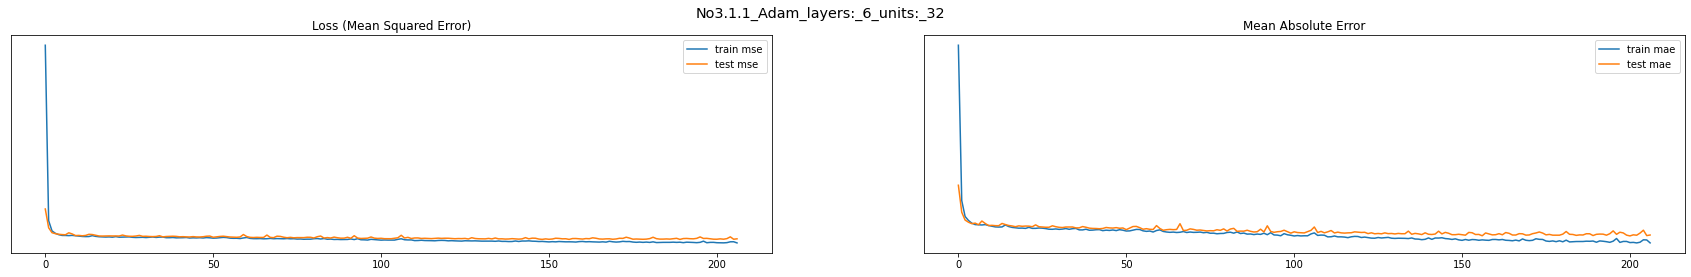

                                      type  mean_squared_error  \
0  train:_No3.1.1_Adam_layers:_6_units:_32              12.322   
1   test:_No3.1.1_Adam_layers:_6_units:_32              15.302   
2         No3.1.1_Adam_layers:_6_units:_32               2.980   

   mean_absolute_error  r2_score  e_v_score  
0                2.598    95.757     95.856  
1                2.888    94.780     94.862  
2                0.290     0.977      0.994  

Epoch 1: val_loss improved from inf to 0.03425, saving model to /content/drive/MyDrive/Colab Notebooks/4.ML_ANN_Project/weights_and_models/resnet-weights_No3.1.1_Adam_layers:_6_units:_64.hdf5

Epoch 2: val_loss improved from 0.03425 to 0.02371, saving model to /content/drive/MyDrive/Colab Notebooks/4.ML_ANN_Project/weights_and_models/resnet-weights_No3.1.1_Adam_layers:_6_units:_64.hdf5

Epoch 3: val_loss improved from 0.02371 to 0.02256, saving model to /content/drive/MyDrive/Colab Notebooks/4.ML_ANN_Project/weights_and_models/resnet-weights_No

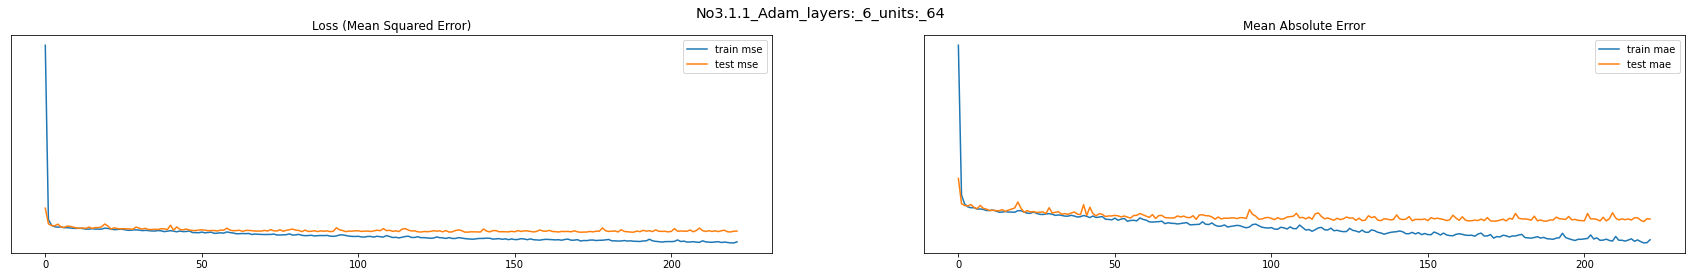

                                      type  mean_squared_error  \
0  train:_No3.1.1_Adam_layers:_6_units:_64               9.017   
1   test:_No3.1.1_Adam_layers:_6_units:_64              15.189   
2         No3.1.1_Adam_layers:_6_units:_64               6.172   

   mean_absolute_error  r2_score  e_v_score  
0                2.208    96.895     96.913  
1                2.871    94.819     94.833  
2                0.663     2.076      2.080  

Epoch 1: val_loss improved from inf to 0.36222, saving model to /content/drive/MyDrive/Colab Notebooks/4.ML_ANN_Project/weights_and_models/resnet-weights_No3.1.1_Adam_layers:_8_units:_6.hdf5

Epoch 2: val_loss improved from 0.36222 to 0.33887, saving model to /content/drive/MyDrive/Colab Notebooks/4.ML_ANN_Project/weights_and_models/resnet-weights_No3.1.1_Adam_layers:_8_units:_6.hdf5

Epoch 3: val_loss improved from 0.33887 to 0.28578, saving model to /content/drive/MyDrive/Colab Notebooks/4.ML_ANN_Project/weights_and_models/resnet-weights_No3.

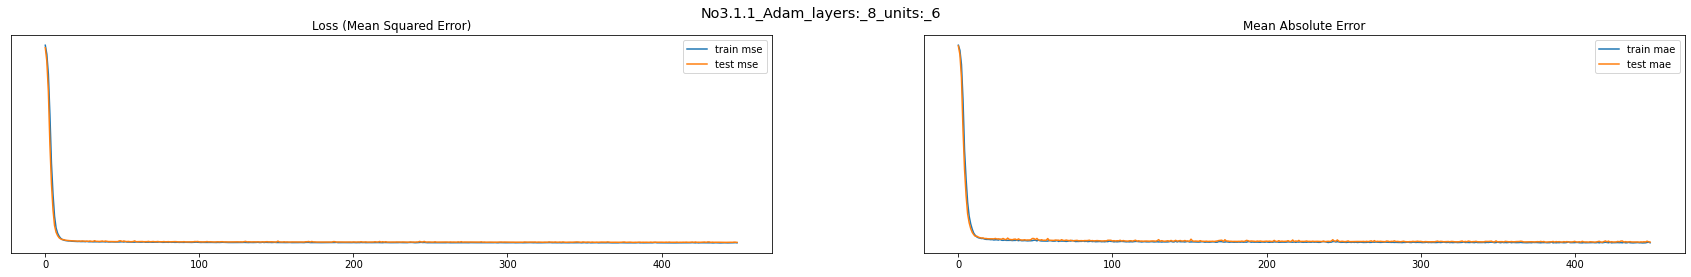

                                     type  mean_squared_error  \
0  train:_No3.1.1_Adam_layers:_8_units:_6              16.458   
1   test:_No3.1.1_Adam_layers:_8_units:_6              17.294   
2         No3.1.1_Adam_layers:_8_units:_6               0.836   

   mean_absolute_error  r2_score  e_v_score  
0                3.136    94.333     94.337  
1                3.189    94.101     94.105  
2                0.053     0.232      0.232  

Epoch 1: val_loss improved from inf to 0.30842, saving model to /content/drive/MyDrive/Colab Notebooks/4.ML_ANN_Project/weights_and_models/resnet-weights_No3.1.1_Adam_layers:_8_units:_8.hdf5

Epoch 2: val_loss improved from 0.30842 to 0.17016, saving model to /content/drive/MyDrive/Colab Notebooks/4.ML_ANN_Project/weights_and_models/resnet-weights_No3.1.1_Adam_layers:_8_units:_8.hdf5

Epoch 3: val_loss improved from 0.17016 to 0.08863, saving model to /content/drive/MyDrive/Colab Notebooks/4.ML_ANN_Project/weights_and_models/resnet-weights_No3.1.1_

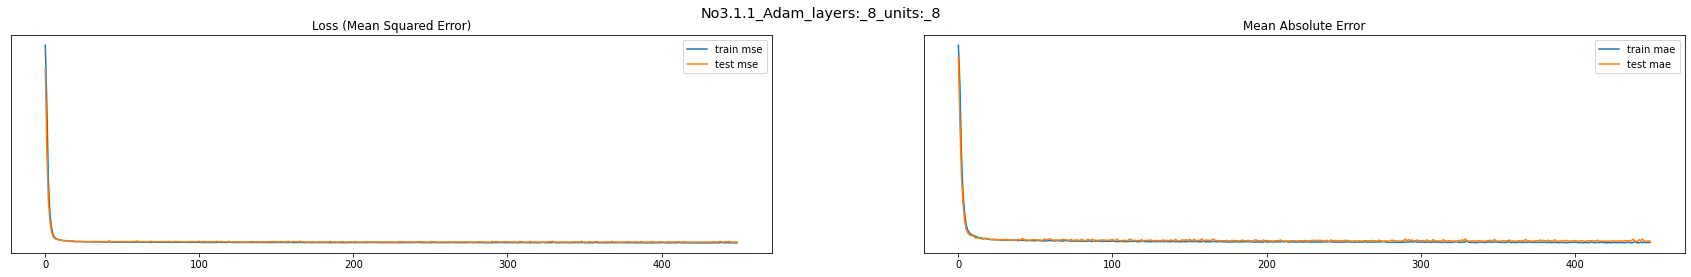

                                     type  mean_squared_error  \
0  train:_No3.1.1_Adam_layers:_8_units:_8              15.663   
1   test:_No3.1.1_Adam_layers:_8_units:_8              16.903   
2         No3.1.1_Adam_layers:_8_units:_8               1.240   

   mean_absolute_error  r2_score  e_v_score  
0                3.000    94.607     94.617  
1                3.116    94.234     94.245  
2                0.116     0.373      0.372  

Epoch 1: val_loss improved from inf to 0.14390, saving model to /content/drive/MyDrive/Colab Notebooks/4.ML_ANN_Project/weights_and_models/resnet-weights_No3.1.1_Adam_layers:_8_units:_16.hdf5

Epoch 2: val_loss improved from 0.14390 to 0.03846, saving model to /content/drive/MyDrive/Colab Notebooks/4.ML_ANN_Project/weights_and_models/resnet-weights_No3.1.1_Adam_layers:_8_units:_16.hdf5

Epoch 3: val_loss improved from 0.03846 to 0.03159, saving model to /content/drive/MyDrive/Colab Notebooks/4.ML_ANN_Project/weights_and_models/resnet-weights_No3.1.

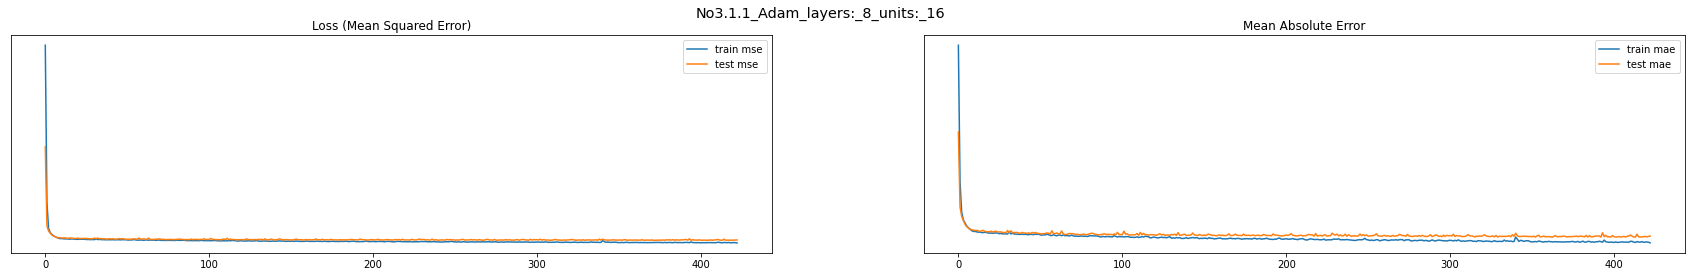

                                      type  mean_squared_error  \
0  train:_No3.1.1_Adam_layers:_8_units:_16              12.813   
1   test:_No3.1.1_Adam_layers:_8_units:_16              15.842   
2         No3.1.1_Adam_layers:_8_units:_16               3.029   

   mean_absolute_error  r2_score  e_v_score  
0                2.696    95.588     95.619  
1                2.985    94.596     94.620  
2                0.289     0.992      0.999  

Epoch 1: val_loss improved from inf to 0.04324, saving model to /content/drive/MyDrive/Colab Notebooks/4.ML_ANN_Project/weights_and_models/resnet-weights_No3.1.1_Adam_layers:_8_units:_32.hdf5

Epoch 2: val_loss improved from 0.04324 to 0.02661, saving model to /content/drive/MyDrive/Colab Notebooks/4.ML_ANN_Project/weights_and_models/resnet-weights_No3.1.1_Adam_layers:_8_units:_32.hdf5

Epoch 3: val_loss improved from 0.02661 to 0.02405, saving model to /content/drive/MyDrive/Colab Notebooks/4.ML_ANN_Project/weights_and_models/resnet-weights_No

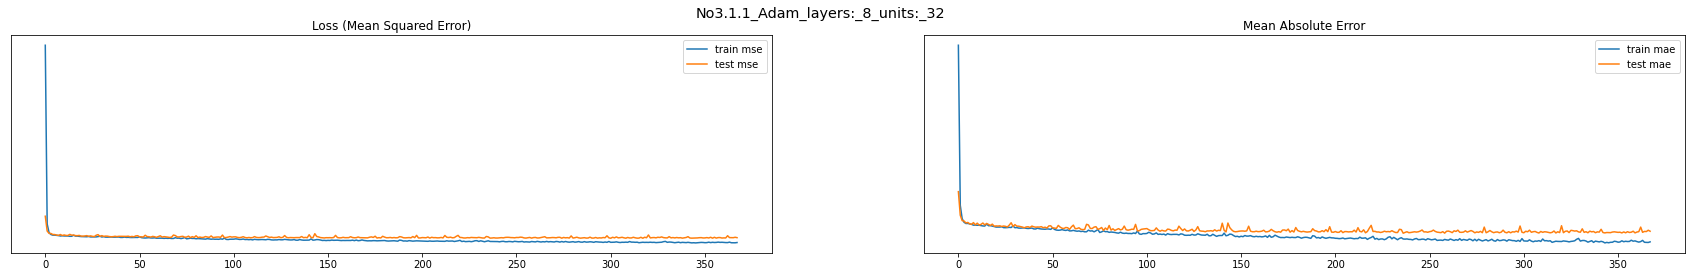

                                      type  mean_squared_error  \
0  train:_No3.1.1_Adam_layers:_8_units:_32              10.894   
1   test:_No3.1.1_Adam_layers:_8_units:_32              15.468   
2         No3.1.1_Adam_layers:_8_units:_32               4.574   

   mean_absolute_error  r2_score  e_v_score  
0                2.465    96.249     96.332  
1                2.917    94.724     94.794  
2                0.452     1.525      1.538  

Epoch 1: val_loss improved from inf to 0.03569, saving model to /content/drive/MyDrive/Colab Notebooks/4.ML_ANN_Project/weights_and_models/resnet-weights_No3.1.1_Adam_layers:_8_units:_64.hdf5

Epoch 2: val_loss improved from 0.03569 to 0.02390, saving model to /content/drive/MyDrive/Colab Notebooks/4.ML_ANN_Project/weights_and_models/resnet-weights_No3.1.1_Adam_layers:_8_units:_64.hdf5

Epoch 3: val_loss improved from 0.02390 to 0.02376, saving model to /content/drive/MyDrive/Colab Notebooks/4.ML_ANN_Project/weights_and_models/resnet-weights_No

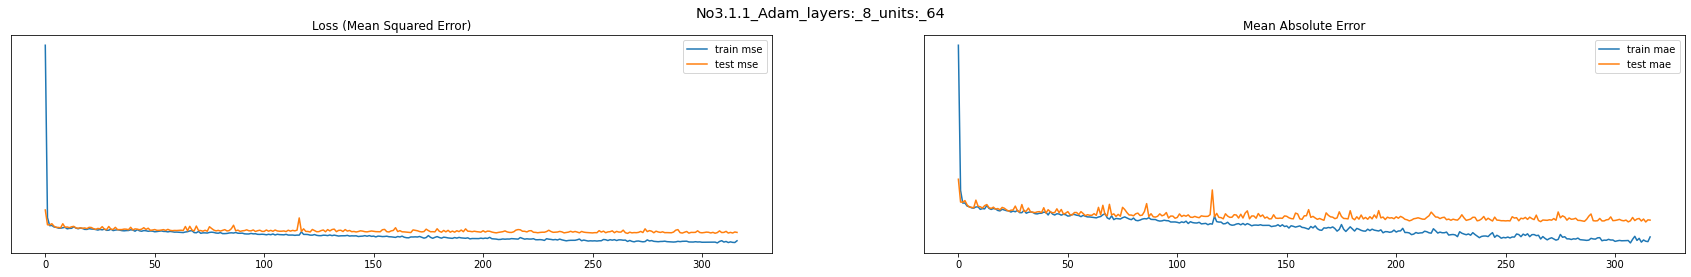

                                      type  mean_squared_error  \
0  train:_No3.1.1_Adam_layers:_8_units:_64               8.000   
1   test:_No3.1.1_Adam_layers:_8_units:_64              14.306   
2         No3.1.1_Adam_layers:_8_units:_64               6.306   

   mean_absolute_error  r2_score  e_v_score  
0                2.055    97.245     97.263  
1                2.755    95.120     95.156  
2                0.700     2.125      2.107  

Epoch 1: val_loss improved from inf to 0.36334, saving model to /content/drive/MyDrive/Colab Notebooks/4.ML_ANN_Project/weights_and_models/resnet-weights_No3.1.1_Adam_layers:_10_units:_6.hdf5

Epoch 2: val_loss improved from 0.36334 to 0.34320, saving model to /content/drive/MyDrive/Colab Notebooks/4.ML_ANN_Project/weights_and_models/resnet-weights_No3.1.1_Adam_layers:_10_units:_6.hdf5

Epoch 3: val_loss improved from 0.34320 to 0.26619, saving model to /content/drive/MyDrive/Colab Notebooks/4.ML_ANN_Project/weights_and_models/resnet-weights_No

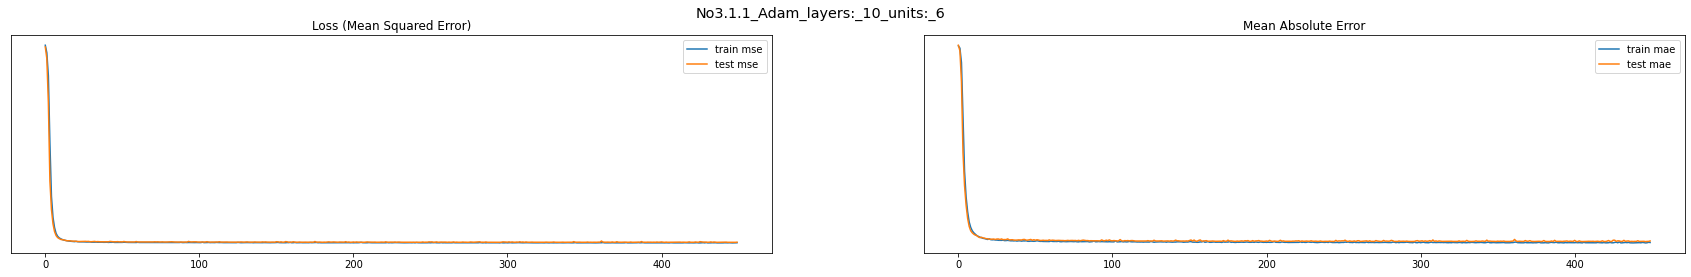

                                      type  mean_squared_error  \
0  train:_No3.1.1_Adam_layers:_10_units:_6              16.777   
1   test:_No3.1.1_Adam_layers:_10_units:_6              17.589   
2         No3.1.1_Adam_layers:_10_units:_6               0.812   

   mean_absolute_error  r2_score  e_v_score  
0                3.143    94.223     94.313  
1                3.226    94.000     94.088  
2                0.083     0.223      0.225  

Epoch 1: val_loss improved from inf to 0.35043, saving model to /content/drive/MyDrive/Colab Notebooks/4.ML_ANN_Project/weights_and_models/resnet-weights_No3.1.1_Adam_layers:_10_units:_8.hdf5

Epoch 2: val_loss improved from 0.35043 to 0.25140, saving model to /content/drive/MyDrive/Colab Notebooks/4.ML_ANN_Project/weights_and_models/resnet-weights_No3.1.1_Adam_layers:_10_units:_8.hdf5

Epoch 3: val_loss improved from 0.25140 to 0.12997, saving model to /content/drive/MyDrive/Colab Notebooks/4.ML_ANN_Project/weights_and_models/resnet-weights_No

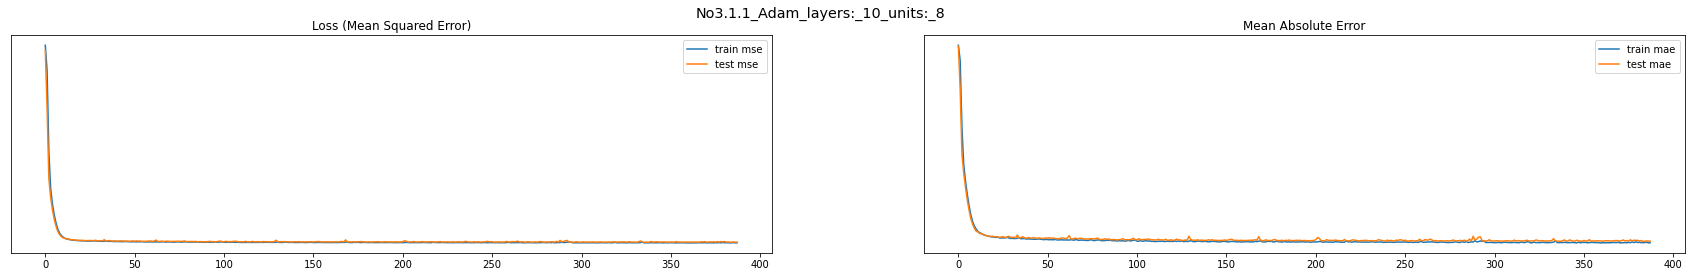

                                      type  mean_squared_error  \
0  train:_No3.1.1_Adam_layers:_10_units:_8              15.590   
1   test:_No3.1.1_Adam_layers:_10_units:_8              16.678   
2         No3.1.1_Adam_layers:_10_units:_8               1.088   

   mean_absolute_error  r2_score  e_v_score  
0                2.974    94.632     94.680  
1                3.090    94.311     94.354  
2                0.116     0.321      0.326  

Epoch 1: val_loss improved from inf to 0.32033, saving model to /content/drive/MyDrive/Colab Notebooks/4.ML_ANN_Project/weights_and_models/resnet-weights_No3.1.1_Adam_layers:_10_units:_16.hdf5

Epoch 2: val_loss improved from 0.32033 to 0.04057, saving model to /content/drive/MyDrive/Colab Notebooks/4.ML_ANN_Project/weights_and_models/resnet-weights_No3.1.1_Adam_layers:_10_units:_16.hdf5

Epoch 3: val_loss improved from 0.04057 to 0.02870, saving model to /content/drive/MyDrive/Colab Notebooks/4.ML_ANN_Project/weights_and_models/resnet-weights_

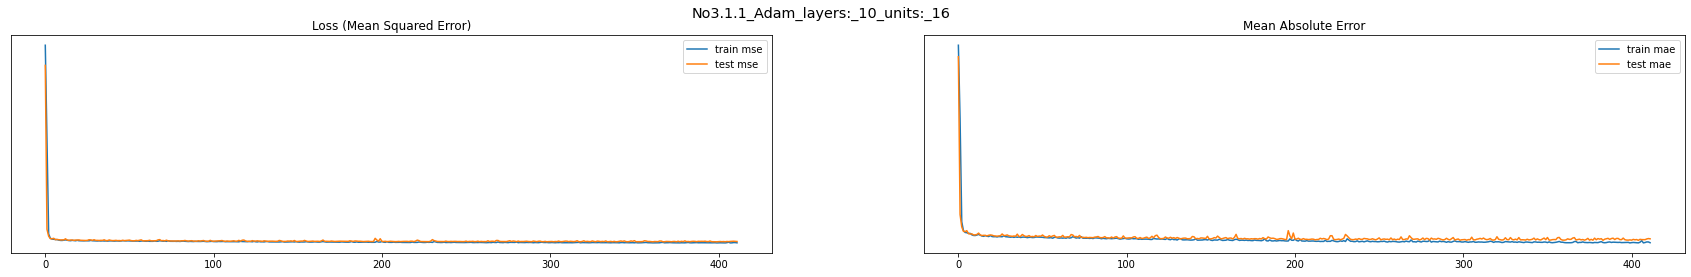

                                       type  mean_squared_error  \
0  train:_No3.1.1_Adam_layers:_10_units:_16              13.996   
1   test:_No3.1.1_Adam_layers:_10_units:_16              15.842   
2         No3.1.1_Adam_layers:_10_units:_16               1.847   

   mean_absolute_error  r2_score  e_v_score  
0                2.841    95.181     95.196  
1                3.027    94.596     94.611  
2                0.186     0.585      0.585  

Epoch 1: val_loss improved from inf to 0.13116, saving model to /content/drive/MyDrive/Colab Notebooks/4.ML_ANN_Project/weights_and_models/resnet-weights_No3.1.1_Adam_layers:_10_units:_32.hdf5

Epoch 2: val_loss improved from 0.13116 to 0.05311, saving model to /content/drive/MyDrive/Colab Notebooks/4.ML_ANN_Project/weights_and_models/resnet-weights_No3.1.1_Adam_layers:_10_units:_32.hdf5

Epoch 3: val_loss improved from 0.05311 to 0.02672, saving model to /content/drive/MyDrive/Colab Notebooks/4.ML_ANN_Project/weights_and_models/resnet-weig

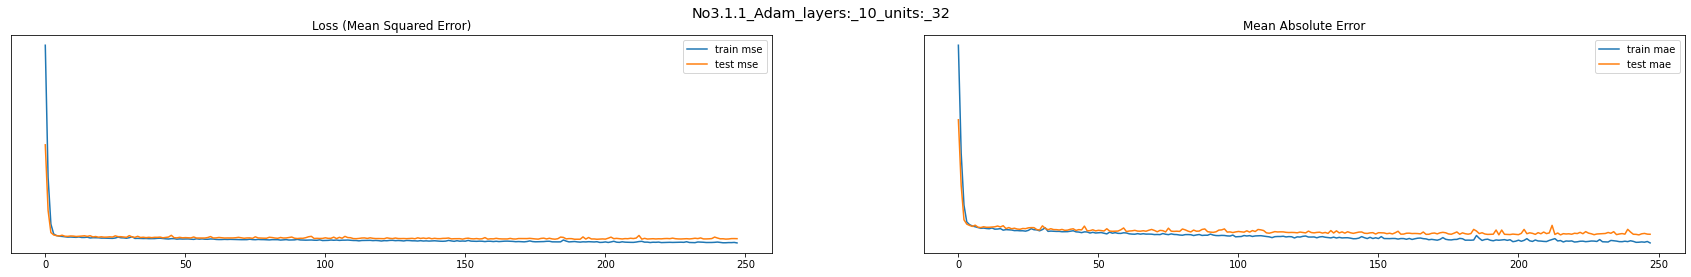

                                       type  mean_squared_error  \
0  train:_No3.1.1_Adam_layers:_10_units:_32              11.767   
1   test:_No3.1.1_Adam_layers:_10_units:_32              15.661   
2         No3.1.1_Adam_layers:_10_units:_32               3.894   

   mean_absolute_error  r2_score  e_v_score  
0                2.509    95.948      96.12  
1                2.912    94.658      94.85  
2                0.402     1.290       1.27  

Epoch 1: val_loss improved from inf to 0.04559, saving model to /content/drive/MyDrive/Colab Notebooks/4.ML_ANN_Project/weights_and_models/resnet-weights_No3.1.1_Adam_layers:_10_units:_64.hdf5

Epoch 2: val_loss improved from 0.04559 to 0.02514, saving model to /content/drive/MyDrive/Colab Notebooks/4.ML_ANN_Project/weights_and_models/resnet-weights_No3.1.1_Adam_layers:_10_units:_64.hdf5

Epoch 3: val_loss improved from 0.02514 to 0.02346, saving model to /content/drive/MyDrive/Colab Notebooks/4.ML_ANN_Project/weights_and_models/resnet-weig

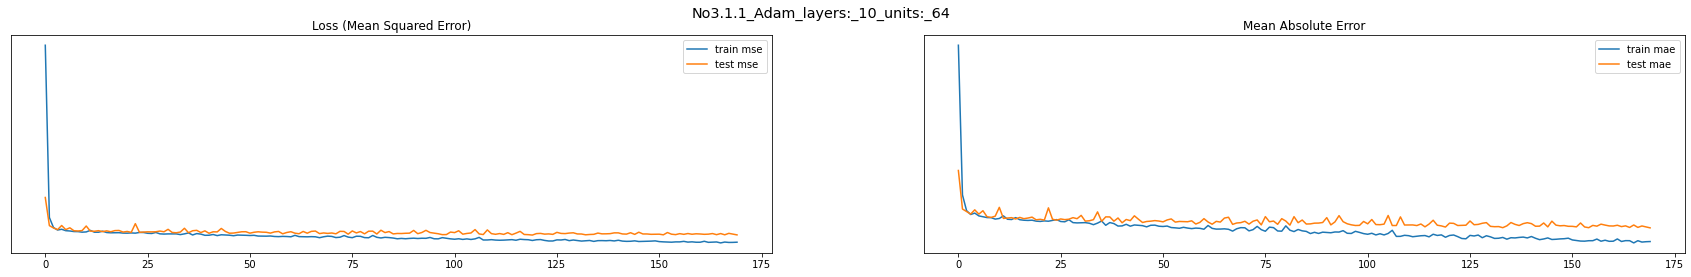

                                       type  mean_squared_error  \
0  train:_No3.1.1_Adam_layers:_10_units:_64               9.440   
1   test:_No3.1.1_Adam_layers:_10_units:_64              14.805   
2         No3.1.1_Adam_layers:_10_units:_64               5.365   

   mean_absolute_error  r2_score  e_v_score  
0                2.209    96.749     96.781  
1                2.810    94.950     94.975  
2                0.601     1.799      1.806  

Epoch 1: val_loss improved from inf to 0.36364, saving model to /content/drive/MyDrive/Colab Notebooks/4.ML_ANN_Project/weights_and_models/resnet-weights_No3.1.1_Adam_layers:_15_units:_6.hdf5

Epoch 2: val_loss improved from 0.36364 to 0.32611, saving model to /content/drive/MyDrive/Colab Notebooks/4.ML_ANN_Project/weights_and_models/resnet-weights_No3.1.1_Adam_layers:_15_units:_6.hdf5

Epoch 3: val_loss improved from 0.32611 to 0.16256, saving model to /content/drive/MyDrive/Colab Notebooks/4.ML_ANN_Project/weights_and_models/resnet-weight

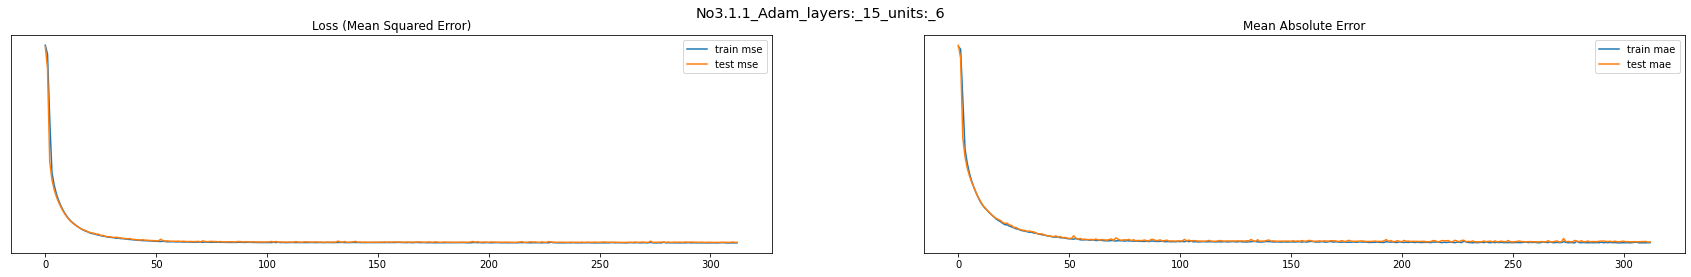

                                      type  mean_squared_error  \
0  train:_No3.1.1_Adam_layers:_15_units:_6              16.654   
1   test:_No3.1.1_Adam_layers:_15_units:_6              17.502   
2         No3.1.1_Adam_layers:_15_units:_6               0.847   

   mean_absolute_error  r2_score  e_v_score  
0                3.129    94.266     94.296  
1                3.195    94.030     94.059  
2                0.065     0.236      0.237  

Epoch 1: val_loss improved from inf to 0.33955, saving model to /content/drive/MyDrive/Colab Notebooks/4.ML_ANN_Project/weights_and_models/resnet-weights_No3.1.1_Adam_layers:_15_units:_8.hdf5

Epoch 2: val_loss improved from 0.33955 to 0.19323, saving model to /content/drive/MyDrive/Colab Notebooks/4.ML_ANN_Project/weights_and_models/resnet-weights_No3.1.1_Adam_layers:_15_units:_8.hdf5

Epoch 3: val_loss improved from 0.19323 to 0.10152, saving model to /content/drive/MyDrive/Colab Notebooks/4.ML_ANN_Project/weights_and_models/resnet-weights_No

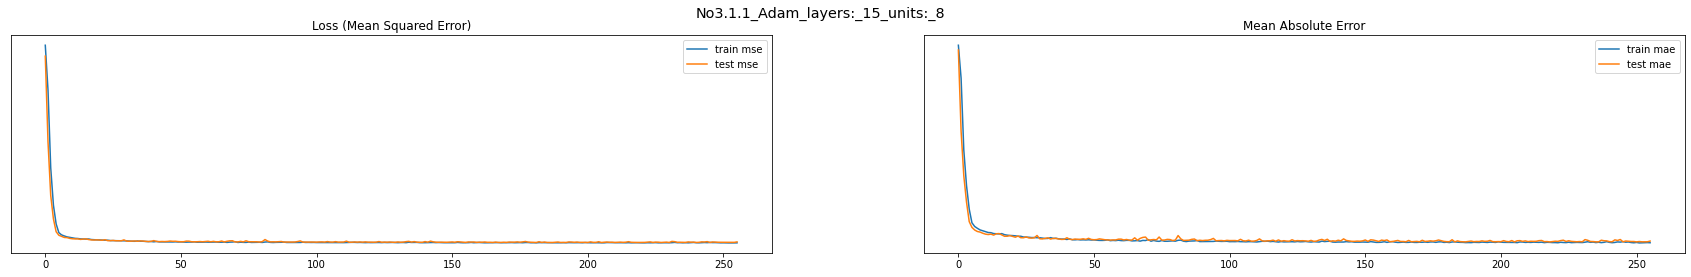

                                      type  mean_squared_error  \
0  train:_No3.1.1_Adam_layers:_15_units:_8              16.868   
1   test:_No3.1.1_Adam_layers:_15_units:_8              17.725   
2         No3.1.1_Adam_layers:_15_units:_8               0.857   

   mean_absolute_error  r2_score  e_v_score  
0                3.127    94.192     94.338  
1                3.204    93.954     94.095  
2                0.077     0.238      0.243  

Epoch 1: val_loss improved from inf to 0.25779, saving model to /content/drive/MyDrive/Colab Notebooks/4.ML_ANN_Project/weights_and_models/resnet-weights_No3.1.1_Adam_layers:_15_units:_16.hdf5

Epoch 2: val_loss improved from 0.25779 to 0.13984, saving model to /content/drive/MyDrive/Colab Notebooks/4.ML_ANN_Project/weights_and_models/resnet-weights_No3.1.1_Adam_layers:_15_units:_16.hdf5

Epoch 3: val_loss improved from 0.13984 to 0.05408, saving model to /content/drive/MyDrive/Colab Notebooks/4.ML_ANN_Project/weights_and_models/resnet-weights_

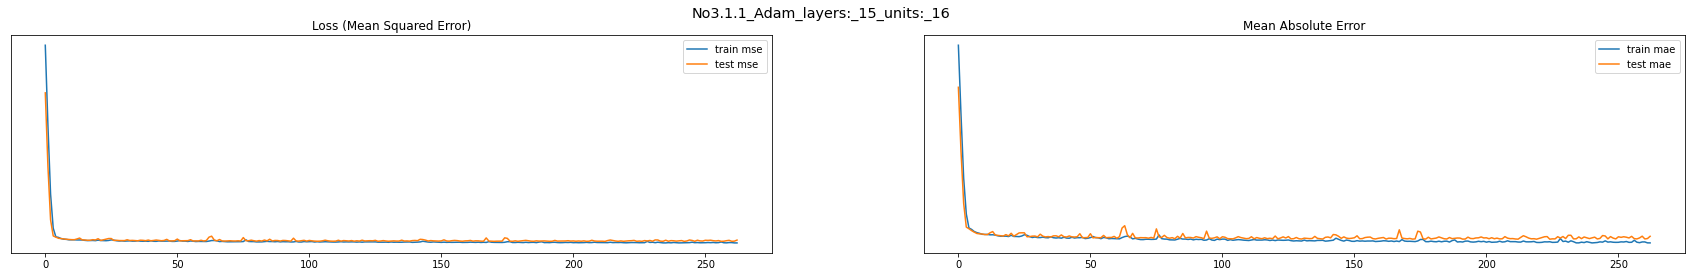

                                       type  mean_squared_error  \
0  train:_No3.1.1_Adam_layers:_15_units:_16              15.000   
1   test:_No3.1.1_Adam_layers:_15_units:_16              17.280   
2         No3.1.1_Adam_layers:_15_units:_16               2.279   

   mean_absolute_error  r2_score  e_v_score  
0                2.914    94.835     95.368  
1                3.136    94.106     94.594  
2                0.222     0.729      0.774  

Epoch 1: val_loss improved from inf to 0.23682, saving model to /content/drive/MyDrive/Colab Notebooks/4.ML_ANN_Project/weights_and_models/resnet-weights_No3.1.1_Adam_layers:_15_units:_32.hdf5

Epoch 2: val_loss improved from 0.23682 to 0.03491, saving model to /content/drive/MyDrive/Colab Notebooks/4.ML_ANN_Project/weights_and_models/resnet-weights_No3.1.1_Adam_layers:_15_units:_32.hdf5

Epoch 3: val_loss improved from 0.03491 to 0.02557, saving model to /content/drive/MyDrive/Colab Notebooks/4.ML_ANN_Project/weights_and_models/resnet-weig

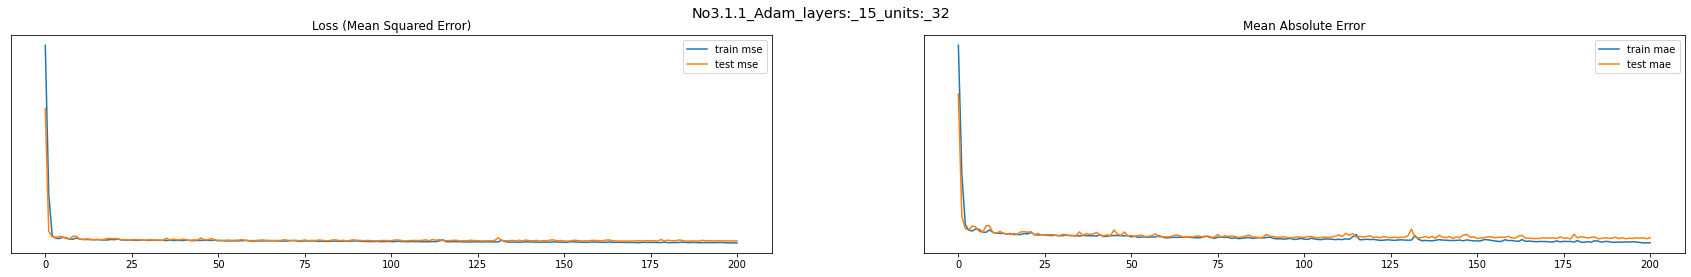

                                       type  mean_squared_error  \
0  train:_No3.1.1_Adam_layers:_15_units:_32              12.634   
1   test:_No3.1.1_Adam_layers:_15_units:_32              15.529   
2         No3.1.1_Adam_layers:_15_units:_32               2.894   

   mean_absolute_error  r2_score  e_v_score  
0                2.646    95.650     95.739  
1                2.931    94.703     94.786  
2                0.285     0.947      0.953  

Epoch 1: val_loss improved from inf to 0.07874, saving model to /content/drive/MyDrive/Colab Notebooks/4.ML_ANN_Project/weights_and_models/resnet-weights_No3.1.1_Adam_layers:_15_units:_64.hdf5

Epoch 2: val_loss improved from 0.07874 to 0.02704, saving model to /content/drive/MyDrive/Colab Notebooks/4.ML_ANN_Project/weights_and_models/resnet-weights_No3.1.1_Adam_layers:_15_units:_64.hdf5

Epoch 3: val_loss improved from 0.02704 to 0.02382, saving model to /content/drive/MyDrive/Colab Notebooks/4.ML_ANN_Project/weights_and_models/resnet-weig

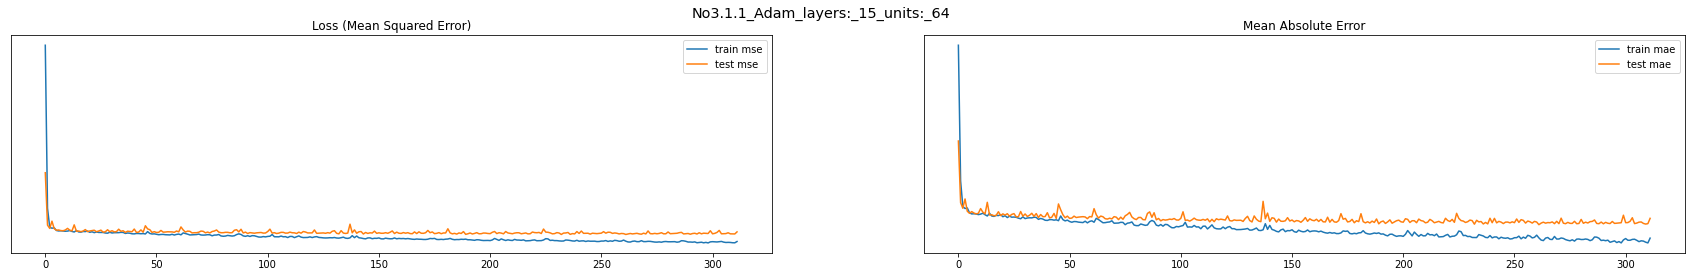

                                       type  mean_squared_error  \
0  train:_No3.1.1_Adam_layers:_15_units:_64               9.494   
1   test:_No3.1.1_Adam_layers:_15_units:_64              16.395   
2         No3.1.1_Adam_layers:_15_units:_64               6.900   

   mean_absolute_error  r2_score  e_v_score  
0                2.271    96.731     96.841  
1                2.996    94.408     94.480  
2                0.725     2.323      2.361  

Epoch 1: val_loss improved from inf to 0.36745, saving model to /content/drive/MyDrive/Colab Notebooks/4.ML_ANN_Project/weights_and_models/resnet-weights_No3.1.1_Adam_layers:_20_units:_6.hdf5

Epoch 2: val_loss improved from 0.36745 to 0.36496, saving model to /content/drive/MyDrive/Colab Notebooks/4.ML_ANN_Project/weights_and_models/resnet-weights_No3.1.1_Adam_layers:_20_units:_6.hdf5

Epoch 3: val_loss improved from 0.36496 to 0.36452, saving model to /content/drive/MyDrive/Colab Notebooks/4.ML_ANN_Project/weights_and_models/resnet-weight

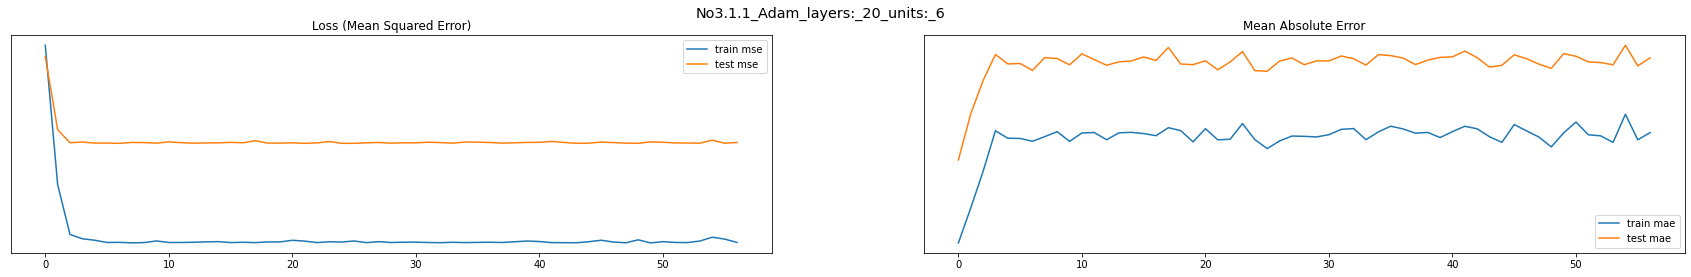

                                      type  mean_squared_error  \
0  train:_No3.1.1_Adam_layers:_20_units:_6             290.428   
1   test:_No3.1.1_Adam_layers:_20_units:_6             293.183   
2         No3.1.1_Adam_layers:_20_units:_6               2.755   

   mean_absolute_error  r2_score  e_v_score  
0               14.818    -0.000        0.0  
1               14.893    -0.008        0.0  
2                0.075     0.008        0.0  

Epoch 1: val_loss improved from inf to 0.36452, saving model to /content/drive/MyDrive/Colab Notebooks/4.ML_ANN_Project/weights_and_models/resnet-weights_No3.1.1_Adam_layers:_20_units:_8.hdf5

Epoch 2: val_loss improved from 0.36452 to 0.36322, saving model to /content/drive/MyDrive/Colab Notebooks/4.ML_ANN_Project/weights_and_models/resnet-weights_No3.1.1_Adam_layers:_20_units:_8.hdf5

Epoch 3: val_loss improved from 0.36322 to 0.32235, saving model to /content/drive/MyDrive/Colab Notebooks/4.ML_ANN_Project/weights_and_models/resnet-weights_No

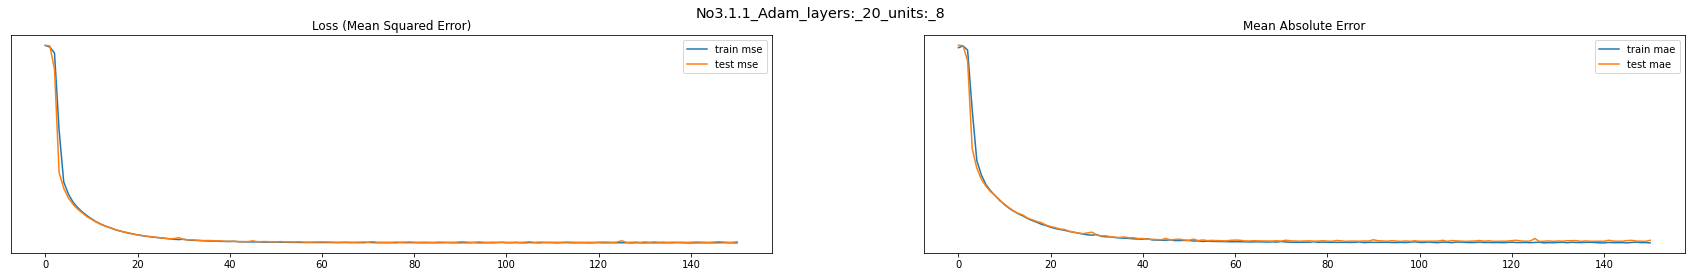

                                      type  mean_squared_error  \
0  train:_No3.1.1_Adam_layers:_20_units:_8              17.420   
1   test:_No3.1.1_Adam_layers:_20_units:_8              18.385   
2         No3.1.1_Adam_layers:_20_units:_8               0.965   

   mean_absolute_error  r2_score  e_v_score  
0                3.198    94.002     94.272  
1                3.289    93.729     93.988  
2                0.091     0.273      0.284  

Epoch 1: val_loss improved from inf to 0.32163, saving model to /content/drive/MyDrive/Colab Notebooks/4.ML_ANN_Project/weights_and_models/resnet-weights_No3.1.1_Adam_layers:_20_units:_16.hdf5

Epoch 2: val_loss improved from 0.32163 to 0.13109, saving model to /content/drive/MyDrive/Colab Notebooks/4.ML_ANN_Project/weights_and_models/resnet-weights_No3.1.1_Adam_layers:_20_units:_16.hdf5

Epoch 3: val_loss improved from 0.13109 to 0.10726, saving model to /content/drive/MyDrive/Colab Notebooks/4.ML_ANN_Project/weights_and_models/resnet-weights_

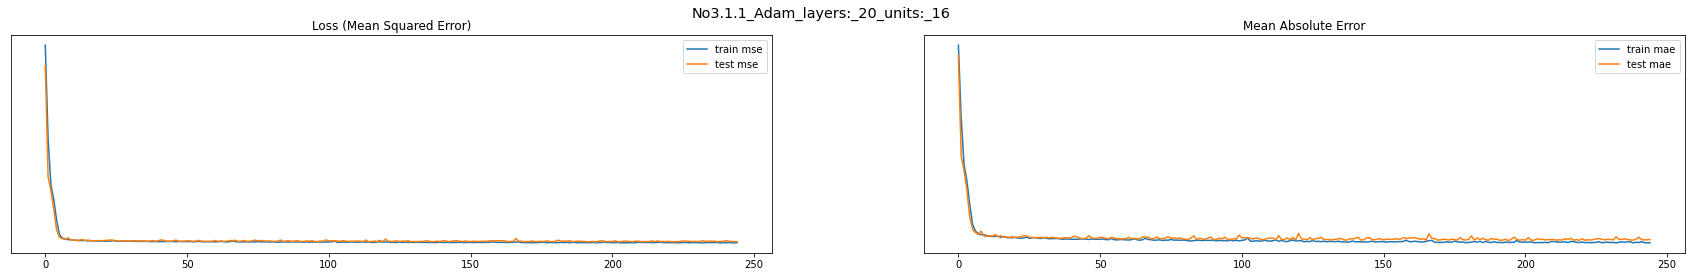

                                       type  mean_squared_error  \
0  train:_No3.1.1_Adam_layers:_20_units:_16              14.850   
1   test:_No3.1.1_Adam_layers:_20_units:_16              16.441   
2         No3.1.1_Adam_layers:_20_units:_16               1.591   

   mean_absolute_error  r2_score  e_v_score  
0                2.945    94.887     94.891  
1                3.105    94.392     94.396  
2                0.160     0.495      0.495  

Epoch 1: val_loss improved from inf to 0.33589, saving model to /content/drive/MyDrive/Colab Notebooks/4.ML_ANN_Project/weights_and_models/resnet-weights_No3.1.1_Adam_layers:_20_units:_32.hdf5

Epoch 2: val_loss improved from 0.33589 to 0.04800, saving model to /content/drive/MyDrive/Colab Notebooks/4.ML_ANN_Project/weights_and_models/resnet-weights_No3.1.1_Adam_layers:_20_units:_32.hdf5

Epoch 3: val_loss improved from 0.04800 to 0.02873, saving model to /content/drive/MyDrive/Colab Notebooks/4.ML_ANN_Project/weights_and_models/resnet-weig

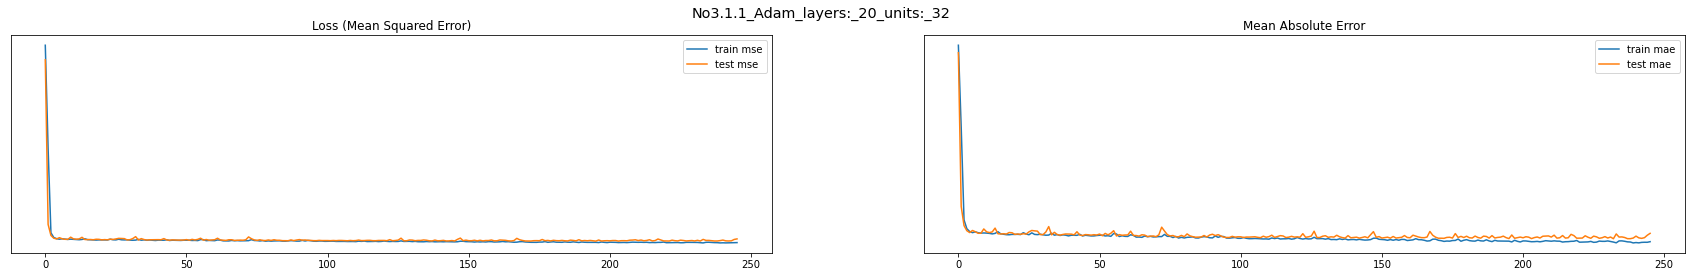

                                       type  mean_squared_error  \
0  train:_No3.1.1_Adam_layers:_20_units:_32              15.116   
1   test:_No3.1.1_Adam_layers:_20_units:_32              18.255   
2         No3.1.1_Adam_layers:_20_units:_32               3.139   

   mean_absolute_error  r2_score  e_v_score  
0                2.970    94.795     95.613  
1                3.225    93.773     94.590  
2                0.255     1.022      1.023  

Epoch 1: val_loss improved from inf to 0.12923, saving model to /content/drive/MyDrive/Colab Notebooks/4.ML_ANN_Project/weights_and_models/resnet-weights_No3.1.1_Adam_layers:_20_units:_64.hdf5

Epoch 2: val_loss improved from 0.12923 to 0.03865, saving model to /content/drive/MyDrive/Colab Notebooks/4.ML_ANN_Project/weights_and_models/resnet-weights_No3.1.1_Adam_layers:_20_units:_64.hdf5

Epoch 3: val_loss improved from 0.03865 to 0.02387, saving model to /content/drive/MyDrive/Colab Notebooks/4.ML_ANN_Project/weights_and_models/resnet-weig

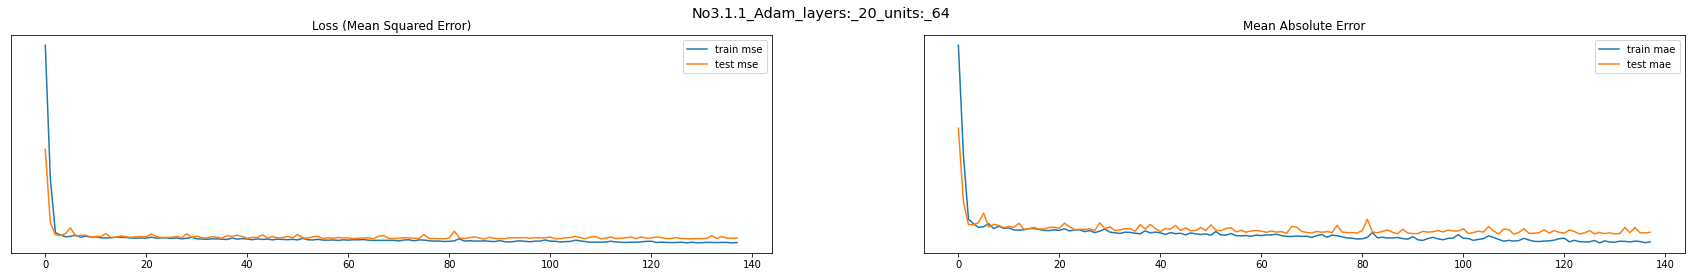

                                       type  mean_squared_error  \
0  train:_No3.1.1_Adam_layers:_20_units:_64              11.434   
1   test:_No3.1.1_Adam_layers:_20_units:_64              16.048   
2         No3.1.1_Adam_layers:_20_units:_64               4.614   

   mean_absolute_error  r2_score  e_v_score  
0                2.478    96.063     96.174  
1                2.956    94.526     94.637  
2                0.478     1.537      1.537  


In [ ]:
rcpr_transformer = FunctionTransformer(lambda x: 1/x, validate = True)
yj_transformer = PowerTransformer(method = 'yeo-johnson', standardize = False)

pipe_complex = define_pipeline_complex(RobustScaler(),yj_transformer, rcpr_transformer, False, True)
X_train, X_test, y_train, y_test, pipe,  y_test_orig, y_train_orig = split_impute_scale_pipe (pp_dataset, pipe_complex, KNNImputer(n_neighbors=2), True, True)
nlayers = [2,4,6,8,10,15,20]
units = [6,8,16,32,64]
for nl in nlayers:
  for u in units:
    complete_run (f"No3.1.1_Adam_layers:_{nl}_units:_{u}",pipe,  n_layers = nl, unt = u)

In [ ]:
show_results(False)

,modelName,train_mse,test_mse,difference
22,No3.1.1_Adam_layers:_8_units:_64,8.000,14.306,6.306
7,No3.1.1_Adam_layers:_2_units:_64,9.685,14.592,4.906
12,No3.1.1_Adam_layers:_4_units:_64,9.433,14.784,5.350
27,No3.1.1_Adam_layers:_10_units:_64,9.440,14.805,5.365
17,No3.1.1_Adam_layers:_6_units:_64,9.017,15.189,6.172
6,No3.1.1_Adam_layers:_2_units:_32,12.987,15.232,2.245
16,No3.1.1_Adam_layers:_6_units:_32,12.322,15.302,2.980
21,No3.1.1_Adam_layers:_8_units:_32,10.894,15.468,4.574
31,No3.1.1_Adam_layers:_15_units:_32,12.634,15.529,2.894
15,No3.1.1_Adam_layers:_6_units:_16,13.874,15.533,1.658


<Figure size 2880x1080 with 0 Axes>

,modelName,train_mse,test_mse,difference
4,No3.1.1_Adam_layers:_2_units:_32,12.987,15.232,2.245
5,No3.1.1_Adam_layers:_6_units:_32,12.322,15.302,2.980
3,No3.1.1_Adam_layers:_6_units:_16,13.874,15.533,1.658
2,RS_RH_AP_winsorize_RCPR_na_ann_knn,16.928,17.442,0.514
1,base_ann,16.975,17.756,0.781
0,basemodel,21.448,22.164,0.716
,modelName,train_mae,test_mae,difference
5,No3.1.1_Adam_layers:_6_units:_32,2.598,2.888,0.290
4,No3.1.1_Adam_layers:_2_units:_32,2.699,2.915,0.216
3,No3.1.1_Adam_layers:_6_units:_16,2.790,2.947,0.157


<Figure size 2880x1080 with 0 Axes>

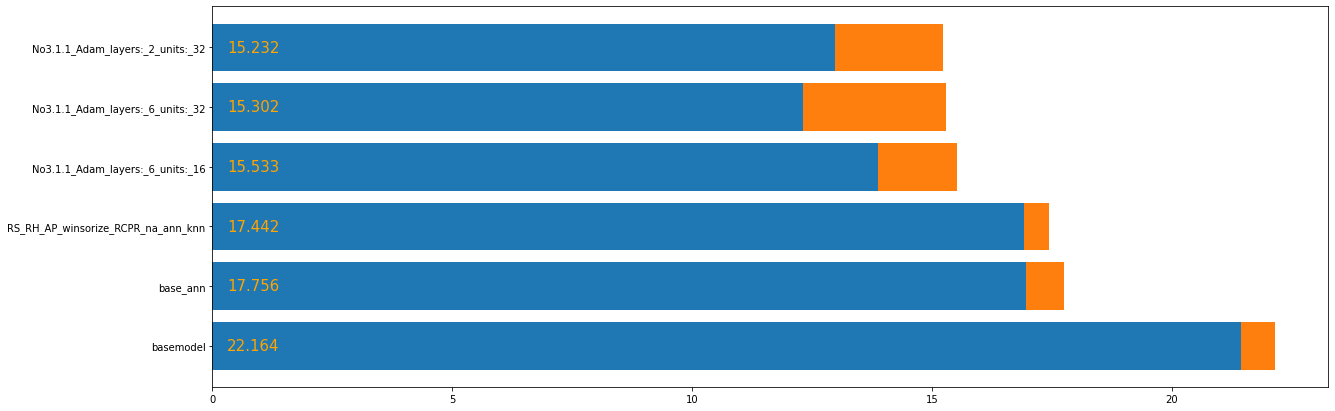

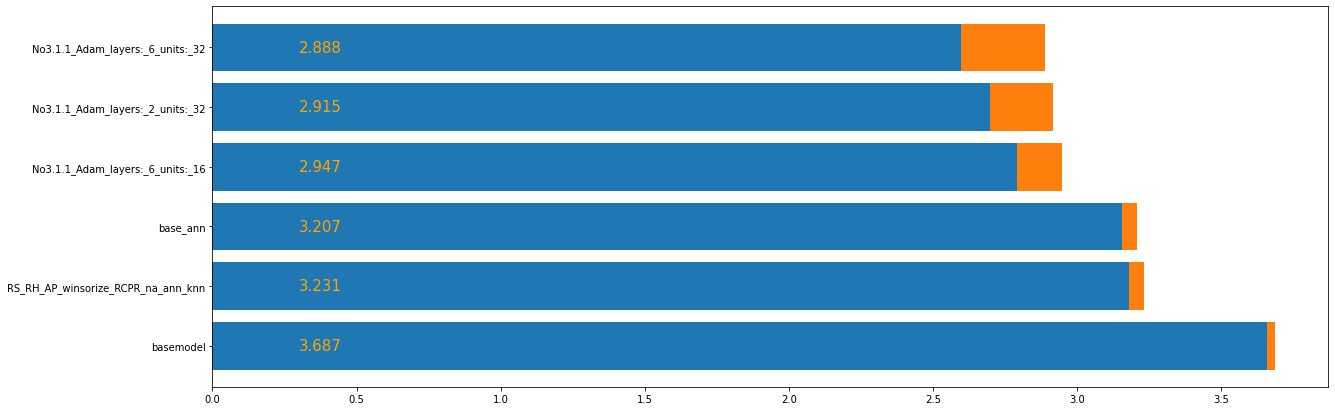

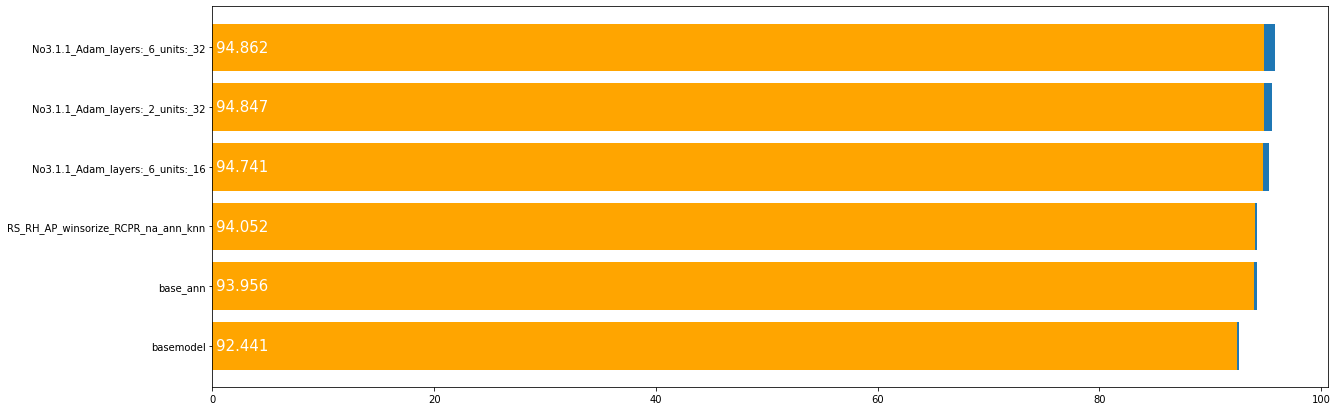

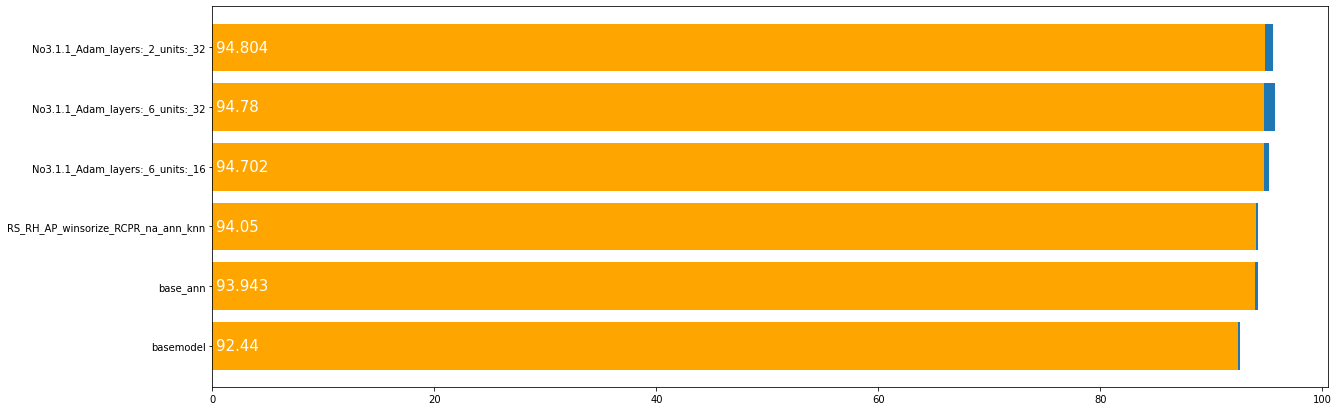

In [ ]:
update_results(True)
show_results()

As there was problem in GitHub (msg: unable to render rich display) file was splitted and the rest of optimizers with conclusion can be found in 4_2_4_PipelineDataPreprocessing_DL-ANN_Project_CPP_SGD_RMSProp_Results